# TP — HealthMind (version finale v2)
**EDA → Nettoyage → Quartiles/IQR → Corrélation (Pearson & Spearman) → ACP (80%) → KMeans (Silhouette & Coude) → Profilage**
*(Commentaires pro + explication après chaque cellule)*

In [1]:
DATA_PATH = r"D:\codePack\OneDrive\Desktop\ProjectsClouds\MentallHealthAwareness\HealthMind_Mental_Health_Data_75k_MultiAlgo.csv"

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder, RobustScaler, StandardScaler,
    LabelEncoder, OrdinalEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

from sklearn.model_selection import (
    train_test_split, cross_val_score,
    GridSearchCV, StratifiedKFold
)
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.naive_bayes import MultinomialNB


import re
from sklearn.feature_extraction.text import TfidfVectorizer

import pickle


import plotly.express as px
import plotly.graph_objects as go



plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)


# pd.set_option("display.max_columns", 200)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

%matplotlib inline


**Explication :** On fixe le chemin du fichier, on importe les librairies (imputation, encodage, scaling, ACP, KMeans, métriques) et on active l'affichage des graphiques.

## 1) Lecture & aperçu

In [2]:
df = pd.read_csv(DATA_PATH)
df = df.drop('User_ID', axis=1) 
print("Shape (lignes, colonnes):", df.shape)
display(df.head(5))
display(df.dtypes.to_frame("dtype"))
display(df.nunique().sort_values(ascending=False).to_frame("n_unique"))


Shape (lignes, colonnes): (75000, 13)


,Age,Gender,Education_Level,Employment_Status,Work_Hours_Week,Sleep_Hours_Night,Exercise_Freq_Week,Financial_Strain,Relationship_Quality,GAD-7_Score,PHQ-9_Score,Stress_Level_Scale,Risk_Level
0,18,Female,Ph.D.,NaN,51.97,8.21,4.00,1.24,10.00,4.00,8.00,2,Low
1,73,Male,Masters,Student,0.00,9.41,0.00,2.67,7.53,7.00,9.00,2,Low
2,40,Female,Masters,Employed,31.56,7.43,0.00,5.05,6.10,13.00,17.00,4,Low
3,38,Female,Masters,Student,0.00,5.14,2.00,4.24,6.76,12.00,14.00,3,Low
4,18,Male,Masters,Self-employed,49.31,7.16,NaN,4.87,8.83,12.00,13.00,3,Low


,dtype
Age,int64
Gender,object
Education_Level,object
Employment_Status,object
Work_Hours_Week,float64
Sleep_Hours_Night,float64
Exercise_Freq_Week,float64
Financial_Strain,float64
Relationship_Quality,float64
GAD-7_Score,float64


,n_unique
Relationship_Quality,69858
Sleep_Hours_Night,63372
Financial_Strain,61351
Work_Hours_Week,44161
Age,68
PHQ-9_Score,24
GAD-7_Score,18
Stress_Level_Scale,10
Exercise_Freq_Week,8
Employment_Status,5


**Explication :** On charge les données et on affiche un aperçu, les types et le nombre de valeurs uniques.

### 1.2 Valeurs manquantes & statistiques


Missing Values Summary:
                    Missing_Count  Missing_Pct
Education_Level             11250        15.00
Employment_Status           11250        15.00
Exercise_Freq_Week          11250        15.00
Sleep_Hours_Night           11240        14.99
Work_Hours_Week             11236        14.98
GAD-7_Score                  1716         2.29
PHQ-9_Score                  1716         2.29


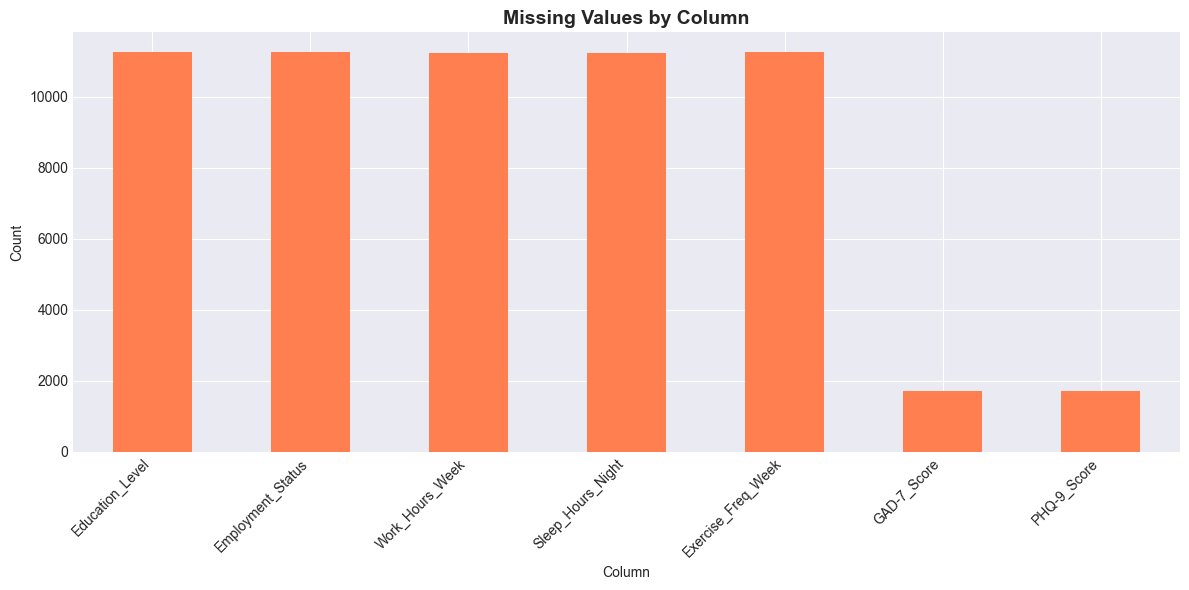


--------------------------------------------------------------------------------
Descriptive Statistics (Numerical Variables):
--------------------------------------------------------------------------------
                        count  mean   std    min   25%   50%   75%    max
Age                  75000.00 38.07 13.05  18.00 28.00 38.00 47.00  85.00
Work_Hours_Week      63764.00 35.05 25.68   0.00  0.00 43.12 54.37 249.00
Sleep_Hours_Night    63760.00  7.20  1.80   0.12  5.99  7.20  8.42  12.00
Exercise_Freq_Week   63750.00  3.51  2.29   0.00  2.00  4.00  5.00   7.00
Financial_Strain     75000.00  4.22  2.53   1.00  1.96  4.01  6.03  10.00
Relationship_Quality 75000.00  6.85  3.54 -99.00  5.65  6.99  8.34  10.00
GAD-7_Score          73284.00 10.94  4.41   4.00  7.00 10.00 14.00  21.00
PHQ-9_Score          73284.00 13.82  5.54   4.00  9.00 13.00 18.00  27.00
Stress_Level_Scale   75000.00  3.40  1.57   1.00  2.00  3.00  4.00  10.00

--------------------------------------------------

In [3]:
missing_count = df.isna().sum()
missing_pct = (df.isna().mean() * 100).round(2)
missing_table = pd.DataFrame({
    'Missing_Count': missing_count,
    'Missing_Pct': missing_pct
}).sort_values('Missing_Count', ascending=False)

print("\nMissing Values Summary:")
print(missing_table[missing_table['Missing_Count'] > 0])

if missing_count.sum() > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    missing_count[missing_count > 0].plot(kind='bar', ax=ax, color='coral')
    ax.set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    ax.set_ylabel('Count')
    ax.set_xlabel('Column')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("✓ No missing values detected")

print("\n" + "-" * 80)
print("Descriptive Statistics (Numerical Variables):")
print("-" * 80)
print(df.describe().T)

cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    print("\n" + "-" * 80)
    print("Descriptive Statistics (Categorical Variables):")
    print("-" * 80)
    for col in cat_cols:
        print(f"\n{col}:")
        print(df[col].value_counts())
        print(f"  Unique values: {df[col].nunique()}")

**Explication :** On quantifie les manquants et on consulte les statistiques descriptives (min, max, quartiles).

### 1.3 Visualisations — distributions & outliers


Analyzing 9 numerical variables...


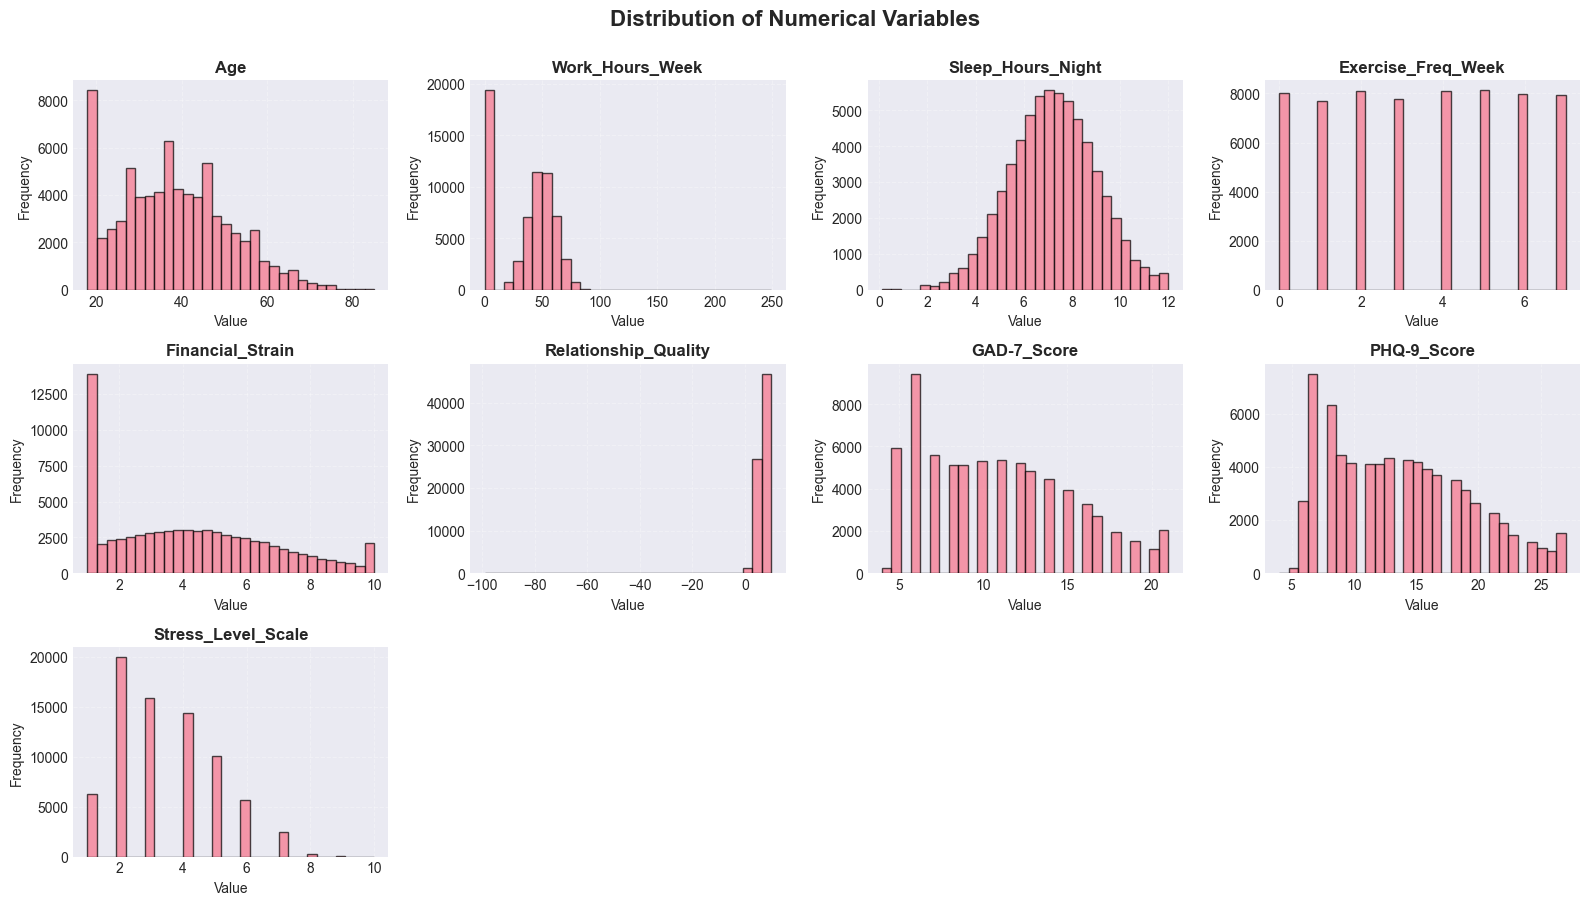

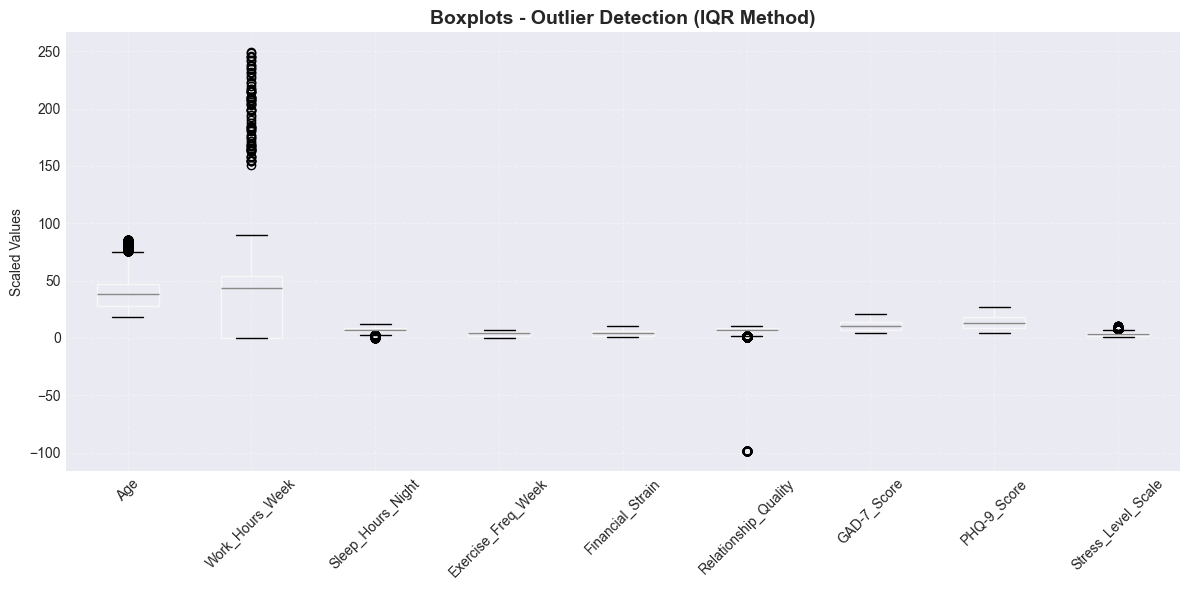


Distribution of Risk Levels:
Risk_Level
Low       55154
Medium    15798
High       4048
Name: count, dtype: int64

Percentages:
Risk_Level
Low      73.54
Medium   21.06
High      5.40
Name: count, dtype: float64


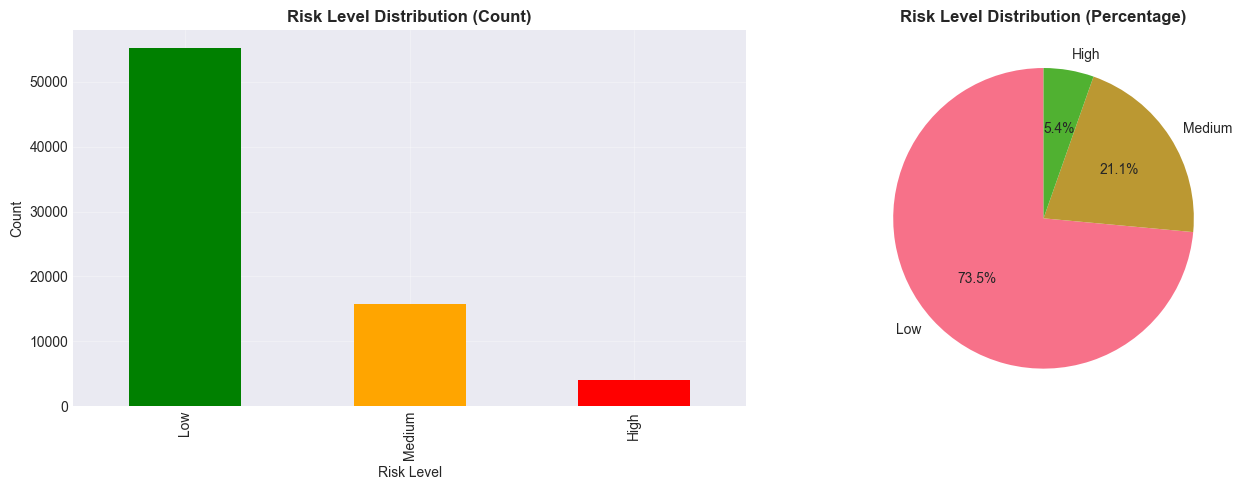

In [4]:
num_cols_all = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'User_ID' in num_cols_all:
    num_cols_all.remove('User_ID')

print(f"\nAnalyzing {len(num_cols_all)} numerical variables...")

n_cols = len(num_cols_all)
n_plot_cols = 4
n_rows = int(np.ceil(n_cols / n_plot_cols))

if n_cols > 0:
    fig, axes = plt.subplots(n_rows, n_plot_cols, figsize=(n_plot_cols * 4, n_rows * 3))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for i, col in enumerate(num_cols_all):
        axes[i].hist(df[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{col}', fontweight='bold')
        axes[i].set_xlabel('Value')
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True, linestyle='--', alpha=0.3)

    for i in range(n_cols, len(axes)):
        axes[i].axis('off')

    plt.suptitle('Distribution of Numerical Variables', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()

if n_cols > 0:
    fig, ax = plt.subplots(figsize=(max(12, len(num_cols_all) * 0.8), 6))
    df[num_cols_all].boxplot(ax=ax, rot=45)
    ax.set_title('Boxplots - Outlier Detection (IQR Method)', fontsize=14, fontweight='bold')
    ax.set_ylabel('Scaled Values')
    ax.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

if 'Risk_Level' in df.columns:
    print("\nDistribution of Risk Levels:")
    risk_counts = df['Risk_Level'].value_counts()
    print(risk_counts)
    print(f"\nPercentages:")
    print((risk_counts / len(df) * 100).round(2))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    risk_counts.plot(kind='bar', ax=ax1, color=['green', 'orange', 'red'])
    ax1.set_title('Risk Level Distribution (Count)', fontweight='bold')
    ax1.set_xlabel('Risk Level')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)

    risk_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%', startangle=90)
    ax2.set_title('Risk Level Distribution (Percentage)', fontweight='bold')
    ax2.set_ylabel('')

    plt.tight_layout()
    plt.show()

**Explication :** Histogrammes = forme; boxplots = outliers; carte des manquants = pattern de NaN.

## 2) Quartiles & IQR — détection systématique des outliers


IQR Outlier Detection Summary:
               Variable    Q1  Median    Q3   IQR  Lower_Bound  Upper_Bound  Outliers_Count  Outliers_Pct
5  Relationship_Quality  5.65    6.99  8.34  2.68         1.62        12.36             345          0.46
2     Sleep_Hours_Night  5.99    7.20  8.42  2.43         2.34        12.07             275          0.43
8    Stress_Level_Scale  2.00    3.00  4.00  2.00        -1.00         7.00             257          0.34
0                   Age 28.00   38.00 47.00 19.00        -0.50        75.50             222          0.30
1       Work_Hours_Week  0.00   43.12 54.37 54.37       -81.55       135.91              75          0.12
3    Exercise_Freq_Week  2.00    4.00  5.00  3.00        -2.50         9.50               0          0.00
4      Financial_Strain  1.96    4.01  6.03  4.06        -4.13        12.12               0          0.00
6           GAD-7_Score  7.00   10.00 14.00  7.00        -3.50        24.50               0          0.00
7           PH

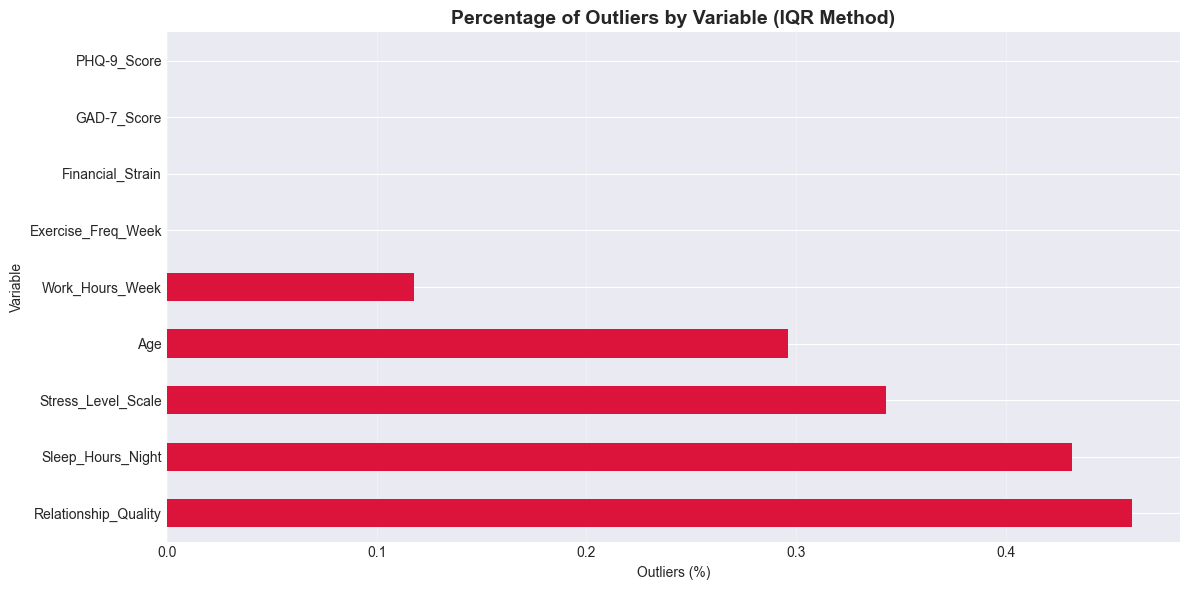

In [5]:
iqr_report = []

for col in num_cols_all:
    s = df[col].dropna()
    if len(s) == 0:
        continue

    Q1 = s.quantile(0.25)
    Q2 = s.quantile(0.50)  
    Q3 = s.quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = ((s < lower_bound) | (s > upper_bound))
    outlier_count = int(outliers.sum())
    outlier_pct = (outlier_count / len(s) * 100)

    iqr_report.append({
        'Variable': col,
        'Q1': Q1,
        'Median': Q2,
        'Q3': Q3,
        'IQR': IQR,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Outliers_Count': outlier_count,
        'Outliers_Pct': outlier_pct
    })

iqr_df = pd.DataFrame(iqr_report).sort_values('Outliers_Count', ascending=False)
print("\nIQR Outlier Detection Summary:")
print(iqr_df.to_string())

fig, ax = plt.subplots(figsize=(12, 6))
iqr_df.plot(x='Variable', y='Outliers_Pct', kind='barh', ax=ax, color='crimson', legend=False)
ax.set_title('Percentage of Outliers by Variable (IQR Method)', fontsize=14, fontweight='bold')
ax.set_xlabel('Outliers (%)')
ax.set_ylabel('Variable')
ax.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


**Explication :** On calcule Q1, médiane, Q3, IQR et les bornes. On compte les outliers par variable.

## 3) Nettoyage — doublons, clipping métier, imputation

In [6]:
n_before = len(df)
df = df.drop_duplicates(ignore_index=True)
n_after = len(df)
n_duplicates = n_before - n_after
print(f"\n✓ Duplicates removed: {n_duplicates:,} rows ({n_duplicates/n_before*100:.2f}%)")
print(f"  Remaining rows: {n_after:,}")

print("\n" + "-" * 80)
print("Applying Business Rules (Clipping):")
print("-" * 80)

rules_clip = {
    "Work_Hours_Week": (0, 100),     
    "Sleep_Hours_Night": (0, 12),    
    "Exercise_Freq_Week": (0, 7),    
    "Stress_Level_Scale": (1, 8),    
    "Age": (16, 80),                 
}

for col, (lo, hi) in rules_clip.items():
    if col in df.columns:
        n_clipped = ((df[col] < lo) | (df[col] > hi)).sum()
        if n_clipped > 0:
            print(f"  {col}: {n_clipped} values clipped to [{lo}, {hi}]")
            df[col] = df[col].clip(lower=lo, upper=hi)
        else:
            print(f"  {col}: ✓ All values within [{lo}, {hi}]")


if 'Sleep_Hours_Night' in df.columns:
    n_invalid = (df['Sleep_Hours_Night'] < 0).sum()
    if n_invalid > 0:
        df.loc[df['Sleep_Hours_Night'] < 0, 'Sleep_Hours_Night'] = np.nan
        print(f"  Sleep_Hours_Night: {n_invalid} negative values set to NaN")

if 'Exercise_Freq_Week' in df.columns:
    n_invalid = (df['Exercise_Freq_Week'] > 7).sum()
    if n_invalid > 0:
        df.loc[df['Exercise_Freq_Week'] > 7, 'Exercise_Freq_Week'] = np.nan
        print(f"  Exercise_Freq_Week: {n_invalid} values > 7 set to NaN")

print("\n" + "-" * 80)
print("Imputation of Missing Values:")
print("-" * 80)

num_cols = df.select_dtypes(include='number').columns.tolist()
cat_cols = df.select_dtypes(exclude='number').columns.tolist()

if 'User_ID' in num_cols:
    num_cols.remove('User_ID')

if num_cols:
    imputer_num = SimpleImputer(strategy='median')
    df[num_cols] = imputer_num.fit_transform(df[num_cols])
    print(f"✓ Numerical columns imputed with median: {len(num_cols)} columns")

if cat_cols:
    imputer_cat = SimpleImputer(strategy='most_frequent')
    df[cat_cols] = imputer_cat.fit_transform(df[cat_cols])
    print(f"✓ Categorical columns imputed with mode: {len(cat_cols)} columns")

n_missing = df.isna().sum().sum()
print(f"\n✓ Total missing values remaining: {n_missing}")



✓ Duplicates removed: 0 rows (0.00%)
  Remaining rows: 75,000

--------------------------------------------------------------------------------
Applying Business Rules (Clipping):
--------------------------------------------------------------------------------
  Work_Hours_Week: 75 values clipped to [0, 100]
  Sleep_Hours_Night: ✓ All values within [0, 12]
  Exercise_Freq_Week: ✓ All values within [0, 7]
  Stress_Level_Scale: 31 values clipped to [1, 8]
  Age: 76 values clipped to [16, 80]

--------------------------------------------------------------------------------
Imputation of Missing Values:
--------------------------------------------------------------------------------
✓ Numerical columns imputed with median: 9 columns
✓ Categorical columns imputed with mode: 4 columns

✓ Total missing values remaining: 0


**Explication :** Doublons retirés, clipping (valeurs impossibles), imputation (médiane/mode).

## 4) Corrélation — Pearson & Spearman (sur X sans ID/étiquette)


Analyzing correlations for 9 numerical features...


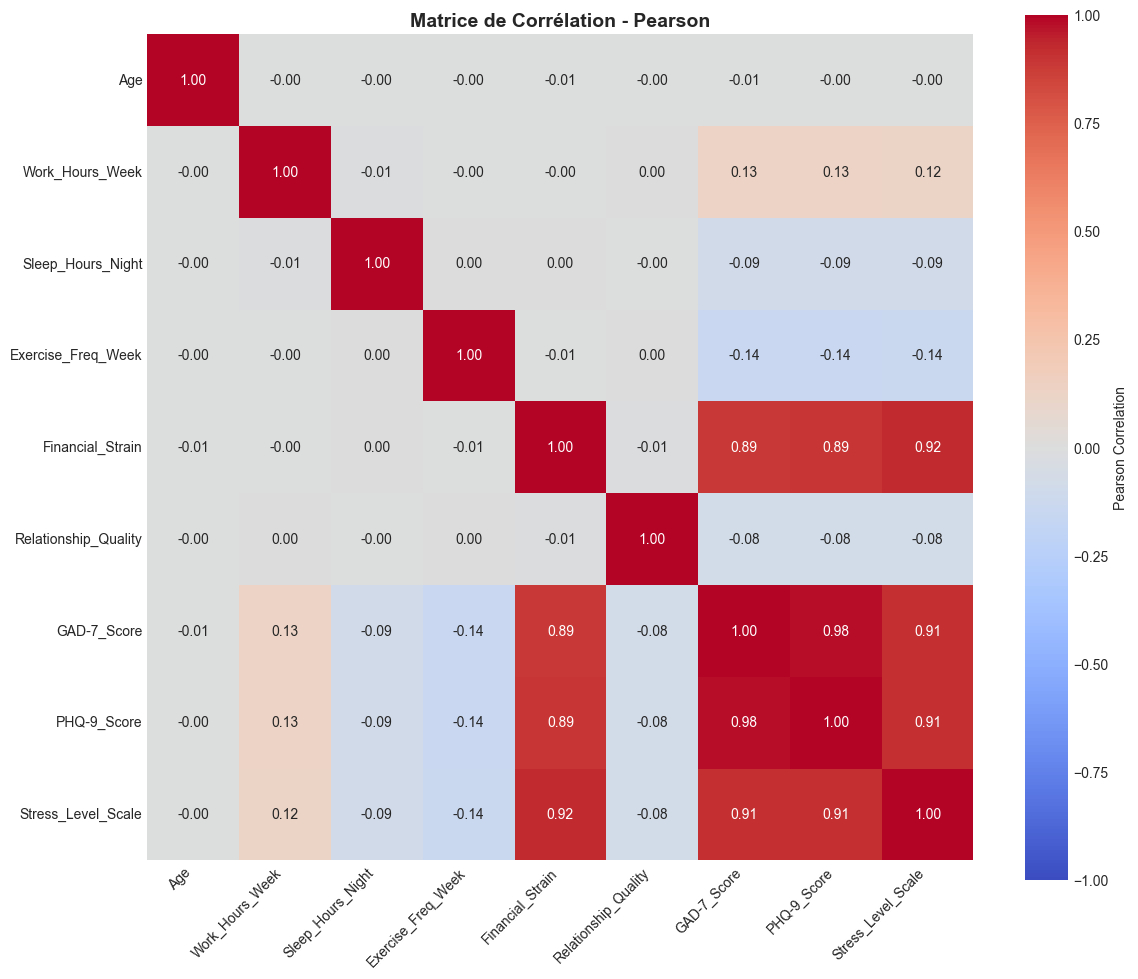


Top correlations (Spearman) with Stress_Level_Scale:
Stress_Level_Scale     1.00
PHQ-9_Score            0.93
GAD-7_Score            0.93
Financial_Strain       0.92
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.11
Sleep_Hours_Night      0.08
Age                    0.00
Name: Stress_Level_Scale, dtype: float64

Top correlations (Spearman) with GAD-7_Score:
GAD-7_Score            1.00
PHQ-9_Score            0.98
Stress_Level_Scale     0.93
Financial_Strain       0.90
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.12
Sleep_Hours_Night      0.09
Age                    0.01
Name: GAD-7_Score, dtype: float64

Top correlations (Spearman) with PHQ-9_Score:
PHQ-9_Score            1.00
GAD-7_Score            0.98
Stress_Level_Scale     0.93
Financial_Strain       0.91
Exercise_Freq_Week     0.14
Work_Hours_Week        0.12
Relationship_Quality   0.12
Sleep_Hours_Night      0.09
Age                    0.01
Name: PHQ-9_Score, dt

In [7]:
drop_cols = []
if 'User_ID' in df.columns:
    drop_cols.append('User_ID')
if 'Risk_Level' in df.columns:
    drop_cols.append('Risk_Level')

X = df.drop(columns=drop_cols, errors='ignore')
num_only = X.select_dtypes(include=['int64', 'float64']).copy()

print(f"\nAnalyzing correlations for {num_only.shape[1]} numerical features...")

corr_pearson = num_only.corr(method='pearson')

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_pearson,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    cbar_kws={'label': 'Pearson Correlation'},
    ax=ax
)
ax.set_title('Matrice de Corrélation - Pearson', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

corr_spearman = num_only.corr(method='spearman')

key_vars = ['Stress_Level_Scale', 'GAD-7_Score', 'PHQ-9_Score']
for var in key_vars:
    if var in corr_spearman.columns:
        print(f"\nTop correlations (Spearman) with {var}:")
        print(corr_spearman[var].abs().sort_values(ascending=False).head(10))

print("\n" + "-" * 80)
print("Highly Correlated Feature Pairs (|r| > 0.8):")
print("-" * 80)

high_corr_pairs = []
for i in range(len(corr_pearson.columns)):
    for j in range(i+1, len(corr_pearson.columns)):
        if abs(corr_pearson.iloc[i, j]) > 0.8:
            high_corr_pairs.append({
                'Var1': corr_pearson.columns[i],
                'Var2': corr_pearson.columns[j],
                'Correlation': corr_pearson.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False)
    print(high_corr_df)
else:
    print("✓ No highly correlated pairs found (threshold: |r| > 0.8)")


**Explication :** Pearson (linéaire) et Spearman (monotone) sur les numériques de X, après exclusion de `User_ID`/`Risk_Level`. 

## 5) Préparation (RobustScaler + OneHot) sur X

In [8]:
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

print(f"\nNumerical features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

X_preprocessed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()

print(f"\n✓ Preprocessing complete:")
print(f"  Original features: {X.shape[1]}")
print(f"  Preprocessed features: {X_preprocessed.shape[1]}")
print(f"  Shape: {X_preprocessed.shape}")



Numerical features: 9
Categorical features: 3

✓ Preprocessing complete:
  Original features: 12
  Preprocessed features: 22
  Shape: (75000, 22)


**Explication :** Pipeline propre et reproductible pour préparer les features.

## 6) ACP — objectif 80% de variance cumulée


PCA Results:
 Components for 80% variance: 7
 Cumulative variance explained: 83.00%


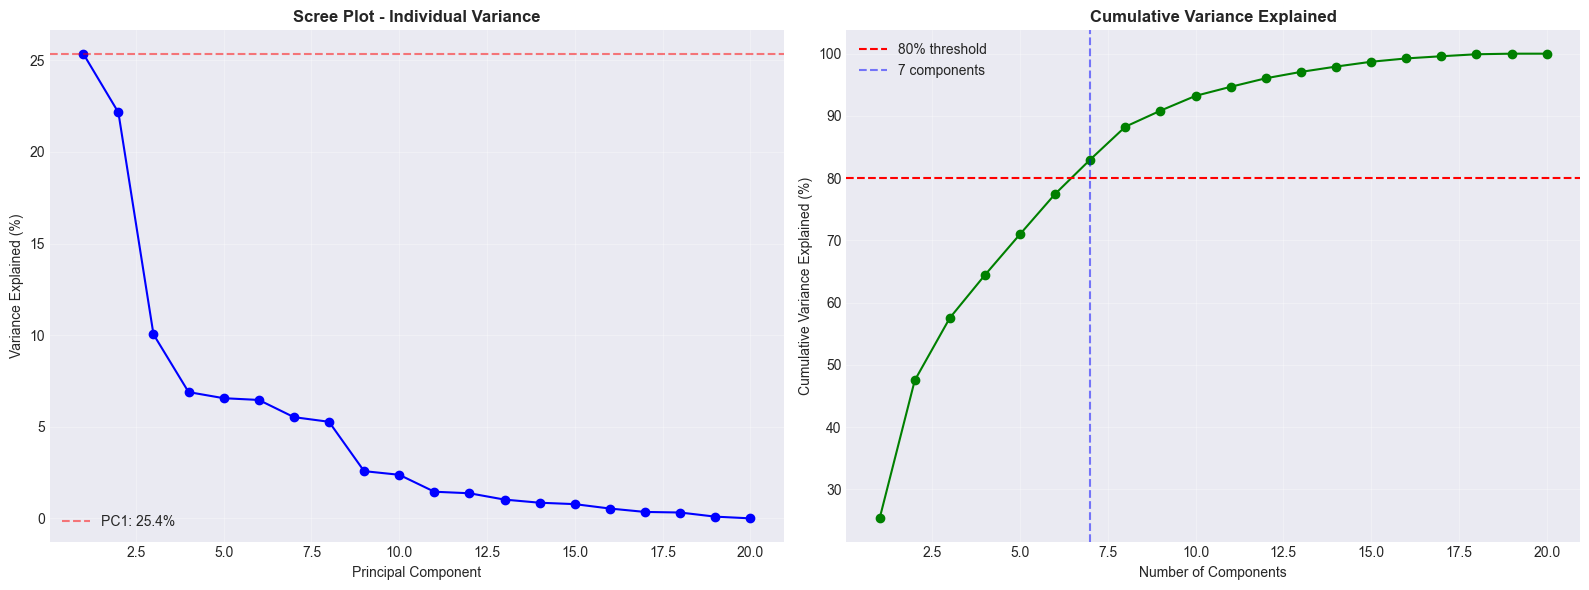


Final PCA shape: (75000, 7)
Variance by component (%):
 PC1: 25.36%
 PC2: 22.16%
 PC3: 10.04%
 PC4: 6.89%
 PC5: 6.56%
 PC6: 6.46%
 PC7: 5.52%


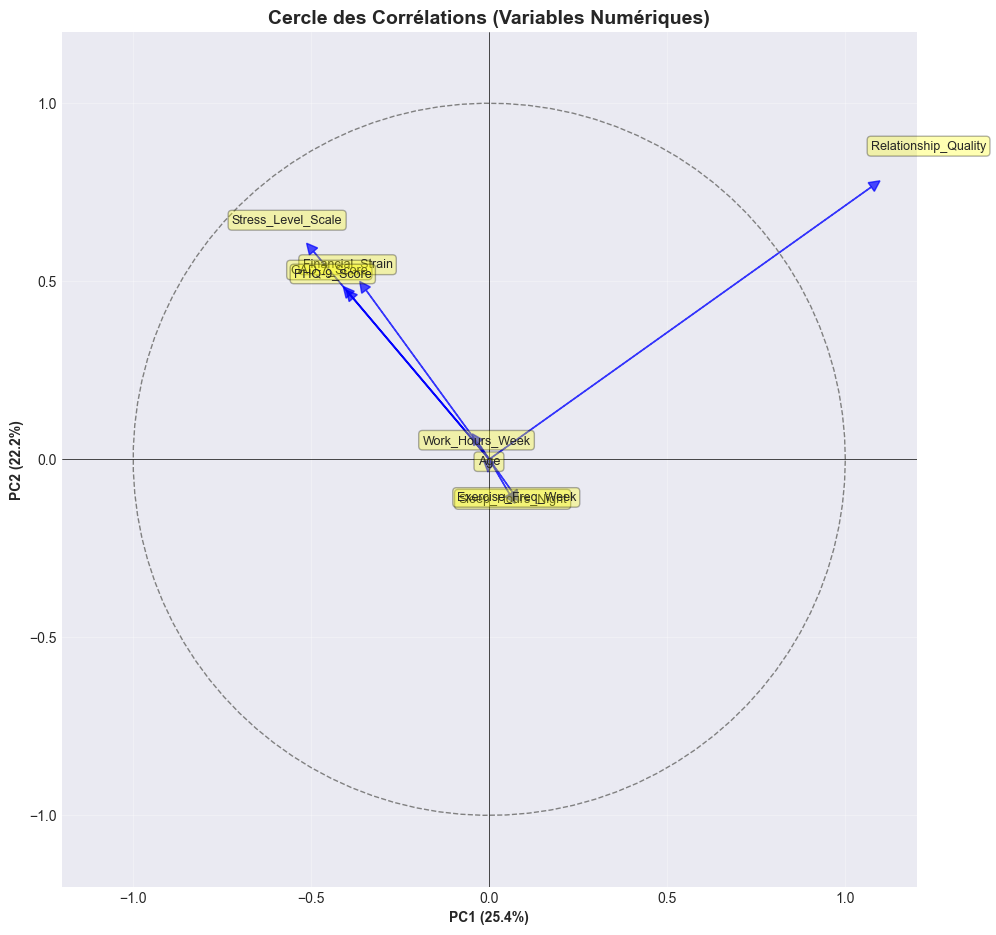


--------------------------------------------------------------------------------
VISUALISATION 3D - Projection PCA (PC1, PC2, PC3)
--------------------------------------------------------------------------------


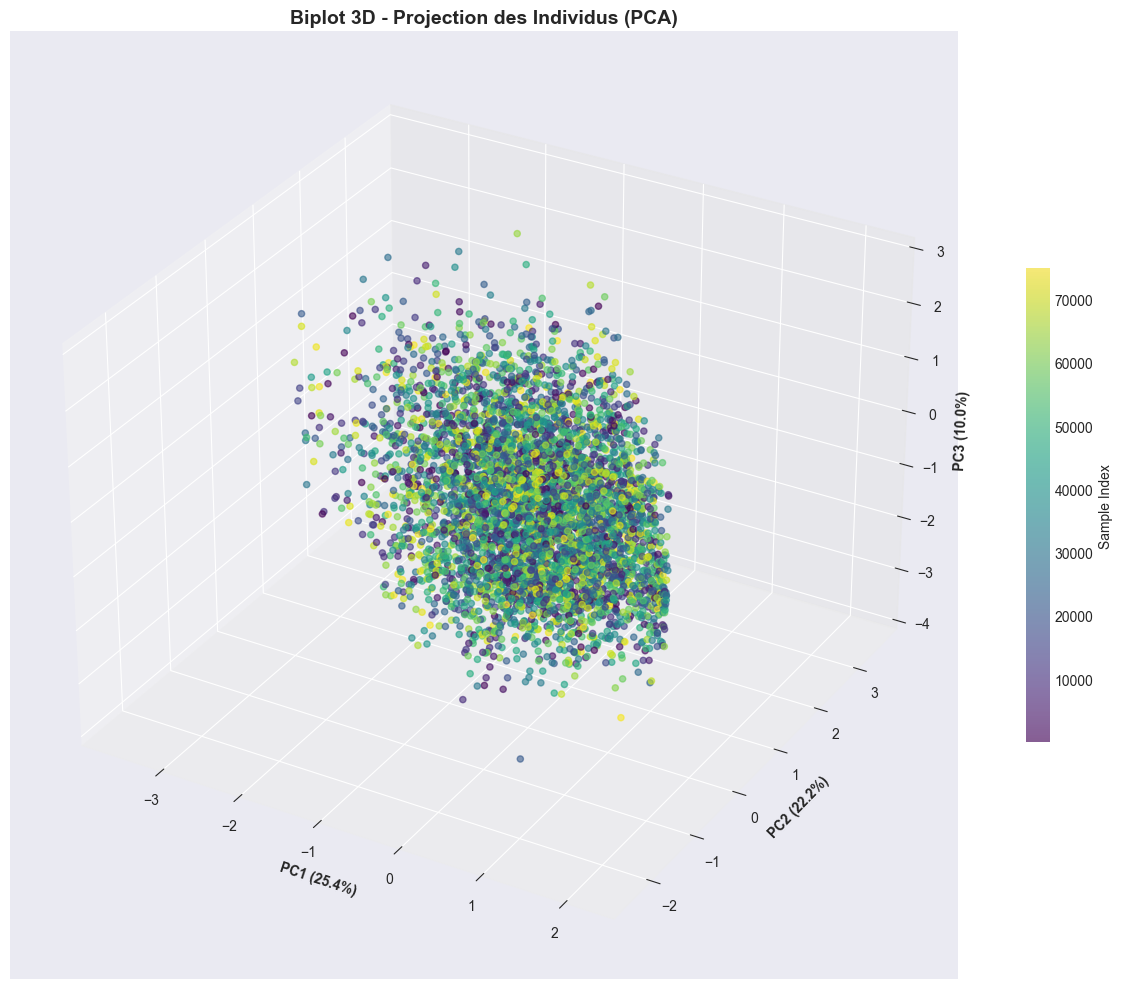

In [9]:
# Initial PCA to analyze variance
n_components_max = min(20, X_preprocessed.shape[1], X_preprocessed.shape[0])
pca_init = PCA(n_components=n_components_max, random_state=RANDOM_STATE)
Z_init = pca_init.fit_transform(X_preprocessed)

# Explained variance
explained_variance = pca_init.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components for 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
if cumulative_variance[-1] < 0.80:
    n_components_80 = len(cumulative_variance)

print(f"\nPCA Results:")
print(f" Components for 80% variance: {n_components_80}")
print(f" Cumulative variance explained: {cumulative_variance[n_components_80-1]*100:.2f}%")

# Scree Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Individual variance
ax1.plot(range(1, len(explained_variance) + 1), explained_variance * 100, 'bo-')
ax1.axhline(y=explained_variance[0] * 100, color='r', linestyle='--', alpha=0.5,
            label=f'PC1: {explained_variance[0]*100:.1f}%')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Variance Explained (%)')
ax1.set_title('Scree Plot - Individual Variance', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Cumulative variance
ax2.plot(range(1, len(cumulative_variance) + 1), cumulative_variance * 100, 'go-')
ax2.axhline(y=80, color='r', linestyle='--', label='80% threshold')
ax2.axvline(x=n_components_80, color='b', linestyle='--', alpha=0.5,
            label=f'{n_components_80} components')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Cumulative Variance Explained (%)')
ax2.set_title('Cumulative Variance Explained', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Final PCA with selected components
pca_final = PCA(n_components=n_components_80, random_state=RANDOM_STATE)
Z = pca_final.fit_transform(X_preprocessed)

print(f"\nFinal PCA shape: {Z.shape}")
print(f"Variance by component (%):")
for i, var in enumerate(pca_final.explained_variance_ratio_):
    print(f" PC{i+1}: {var*100:.2f}%")
    #print(pca_final.feature_names_in_)
    ##print(f" Cumulative: {np.sum(pca_final.explained_variance_ratio_[:i+1])*100:.2f}%")

# Correlation circle (for first 2 PCs)
import re
loadings = pca_final.components_.T * np.sqrt(pca_final.explained_variance_)

# Filter numerical features for correlation circle
num_feature_names = [re.sub(r'^num__', '', f) for f in feature_names if f.startswith('num__')]
num_loadings = loadings[[f.startswith('num__') for f in feature_names]]

fig, ax = plt.subplots(figsize=(10, 10))

# Unit circle
theta = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), '--', color='gray', linewidth=1)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)

# Plot arrows for numerical features
for name, (x, y) in zip(num_feature_names, num_loadings[:, :2]):
    ax.arrow(0, 0, x, y, head_width=0.03, head_length=0.03,
             fc='blue', ec='blue', alpha=0.7)
    ax.text(x * 1.15, y * 1.15, name, ha='center', va='center',
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.3))

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_title('Cercle des Corrélations (Variables Numériques)', fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# NOUVEAU: Biplot en 3D pour mieux visualiser les données volumineuses
print("\n" + "-" * 80)
print("VISUALISATION 3D - Projection PCA (PC1, PC2, PC3)")
print("-" * 80)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample data for visualization if too large
sample_size = min(5000, len(Z))
sample_indices = np.random.choice(len(Z), sample_size, replace=False)

scatter = ax.scatter(Z[sample_indices, 0],
                     Z[sample_indices, 1],
                     Z[sample_indices, 2],
                     c=sample_indices,
                     cmap='viridis',
                     s=20,
                     alpha=0.6)

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.1f}%)', fontweight='bold')
ax.set_title('Biplot 3D - Projection des Individus (PCA)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Sample Index', shrink=0.5)
plt.tight_layout()
plt.show()

**Explication :** On atteint ~80% de variance, cercle des corrélations et biplot pour interpréter les axes.

## 7) CLUSTERING - KMEANS & DBSCAN

## 7.1: K-MEANS CLUSTERING

k=2: Silhouette Score = 0.9254
k=3: Silhouette Score = 0.2284
k=4: Silhouette Score = 0.1359
k=5: Silhouette Score = 0.1243
k=6: Silhouette Score = 0.1181
k=7: Silhouette Score = 0.1189
k=8: Silhouette Score = 0.1134

Best k = 2 (Silhouette = 0.9254)


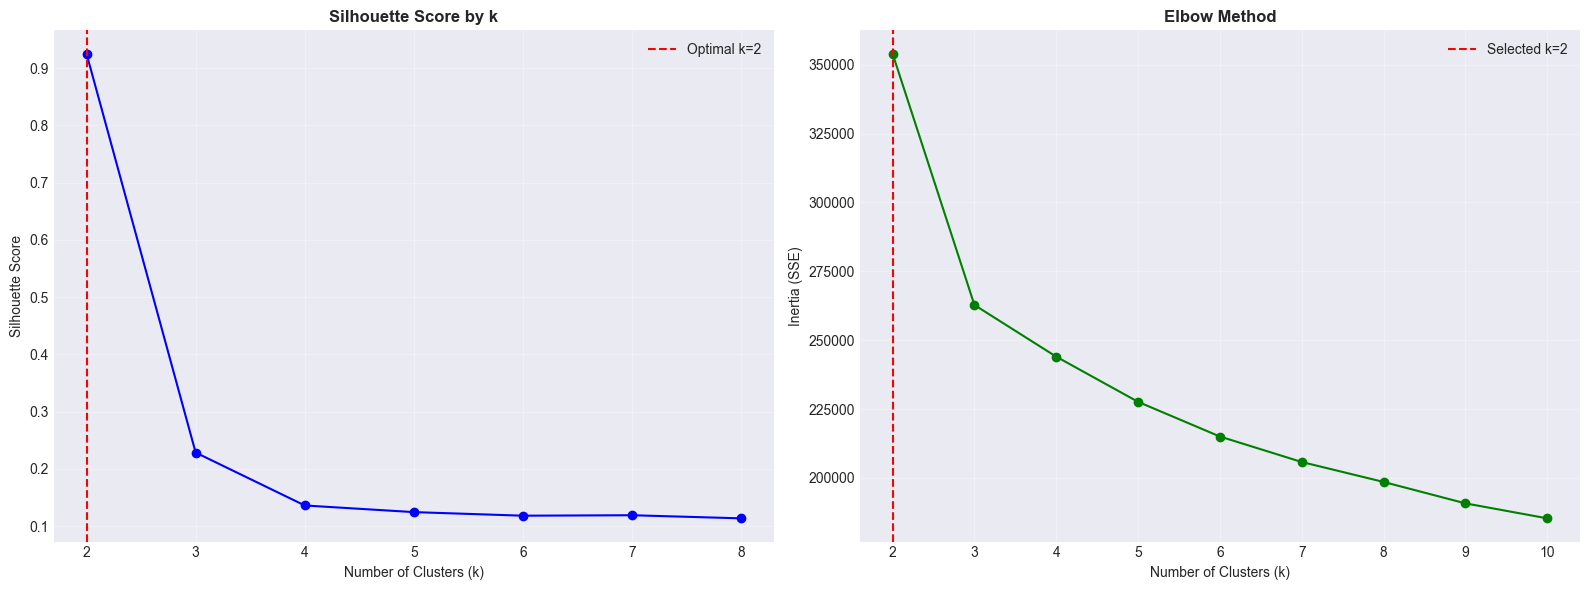


--------------------------------------------------------------------------------
VISUALISATION 3D - K-Means Clustering
--------------------------------------------------------------------------------


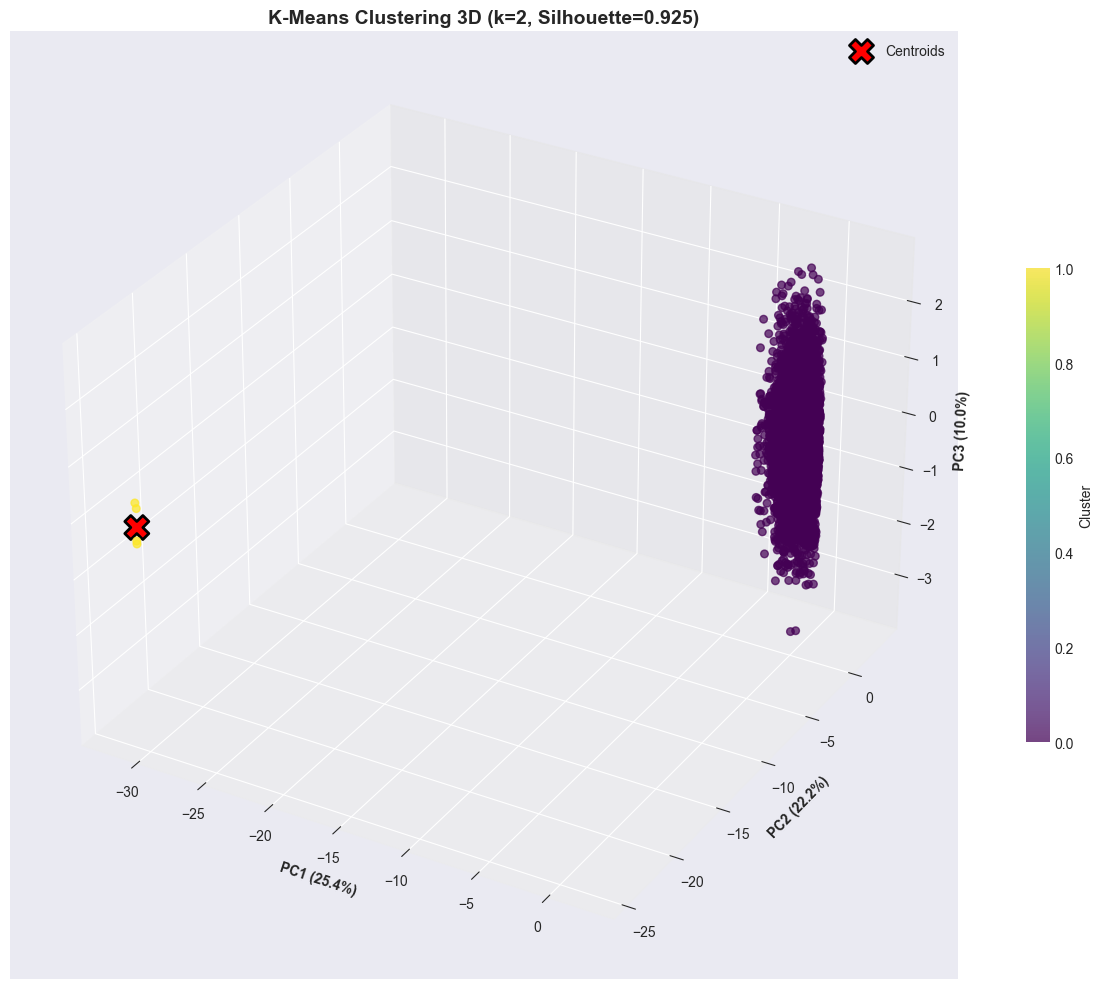


K-Means Cluster Sizes:
KMeans_Cluster
0    74940
1       60
Name: count, dtype: int64

Percentages:
KMeans_Cluster
0   99.92
1    0.08
Name: count, dtype: float64

Cluster Profiles (Numerical - Means):
                 Age  Work_Hours_Week  Sleep_Hours_Night  Exercise_Freq_Week  \
KMeans_Cluster                                                                 
0              38.06            36.16               7.20                3.58   
1              38.33            33.49               7.47                3.57   

                Financial_Strain  Relationship_Quality  GAD-7_Score  \
KMeans_Cluster                                                        
0                           4.22                  6.94        10.92   
1                           5.13                -99.00        11.95   

                PHQ-9_Score  Stress_Level_Scale  
KMeans_Cluster                                   
0                     13.80                3.40  
1                     15.00              

In [10]:
# Silhouette method to find optimal k
silhouette_scores = []
k_range = range(2, 9)

for k in k_range:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    labels = kmeans.fit_predict(Z)
    score = silhouette_score(Z, labels)
    silhouette_scores.append((k, score))
    print(f"k={k}: Silhouette Score = {score:.4f}")

# Find best k
best_k, best_silhouette = max(silhouette_scores, key=lambda x: x[1])
print(f"\nBest k = {best_k} (Silhouette = {best_silhouette:.4f})")

# Elbow method
inertias = []
k_range_elbow = range(2, 11)
for k in k_range_elbow:
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=RANDOM_STATE)
    kmeans.fit(Z)
    inertias.append(kmeans.inertia_)

# Plot Silhouette and Elbow
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Silhouette plot
ax1.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores], 'bo-')
ax1.axvline(x=best_k, color='r', linestyle='--', label=f'Optimal k={best_k}')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Silhouette Score')
ax1.set_title('Silhouette Score by k', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Elbow plot
ax2.plot(k_range_elbow, inertias, 'go-')
ax2.axvline(x=best_k, color='r', linestyle='--', label=f'Selected k={best_k}')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Inertia (SSE)')
ax2.set_title('Elbow Method', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Final K-Means with best k
kmeans_final = KMeans(n_clusters=best_k, n_init=20, random_state=RANDOM_STATE)
kmeans_labels = kmeans_final.fit_predict(Z)

# NOUVEAU: Visualization of K-Means clusters en 3D
print("\n" + "-" * 80)
print("VISUALISATION 3D - K-Means Clustering")
print("-" * 80)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

sample_indices = np.random.choice(len(Z), min(5000, len(Z)), replace=False)
scatter = ax.scatter(Z[sample_indices, 0],
                     Z[sample_indices, 1],
                     Z[sample_indices, 2],
                     c=kmeans_labels[sample_indices],
                     cmap='viridis',
                     s=30,
                     alpha=0.7)

# Plot centroids
centroids = kmeans_final.cluster_centers_
ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
           c='red', s=300, marker='X',
           edgecolors='black', linewidths=2, label='Centroids')

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.1f}%)', fontweight='bold')
ax.set_title(f'K-Means Clustering 3D (k={best_k}, Silhouette={best_silhouette:.3f})',
             fontsize=14, fontweight='bold')
ax.legend()
plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.5)
plt.tight_layout()
plt.show()

# Cluster profiling for K-Means
df_profiling = df.copy()
df_profiling['KMeans_Cluster'] = kmeans_labels

print(f"\nK-Means Cluster Sizes:")
cluster_sizes = df_profiling['KMeans_Cluster'].value_counts().sort_index()
print(cluster_sizes)
print(f"\nPercentages:")
print((cluster_sizes / len(df_profiling) * 100).round(2))

# Numerical profile
num_cols_profile = df.select_dtypes(include=[np.number]).columns.tolist()
if 'User_ID' in num_cols_profile:
    num_cols_profile.remove('User_ID')

profile_means = df_profiling.groupby('KMeans_Cluster')[num_cols_profile].mean().round(2)
print("\nCluster Profiles (Numerical - Means):")
print(profile_means)

# Categorical profile
cat_cols_profile = df.select_dtypes(exclude=[np.number]).columns.tolist()
if cat_cols_profile:
    print("\nCluster Profiles (Categorical - Modes):")
    profile_modes = df_profiling.groupby('KMeans_Cluster')[cat_cols_profile].agg(
        lambda x: x.mode()[0] if len(x.mode()) > 0 else np.nan
    )
    print(profile_modes)


**Explication :** Choix de k avec silhouette + coude, carte des clusters, et profilage (moyennes & modes).

## 7.2: DBSCAN CLUSTERING

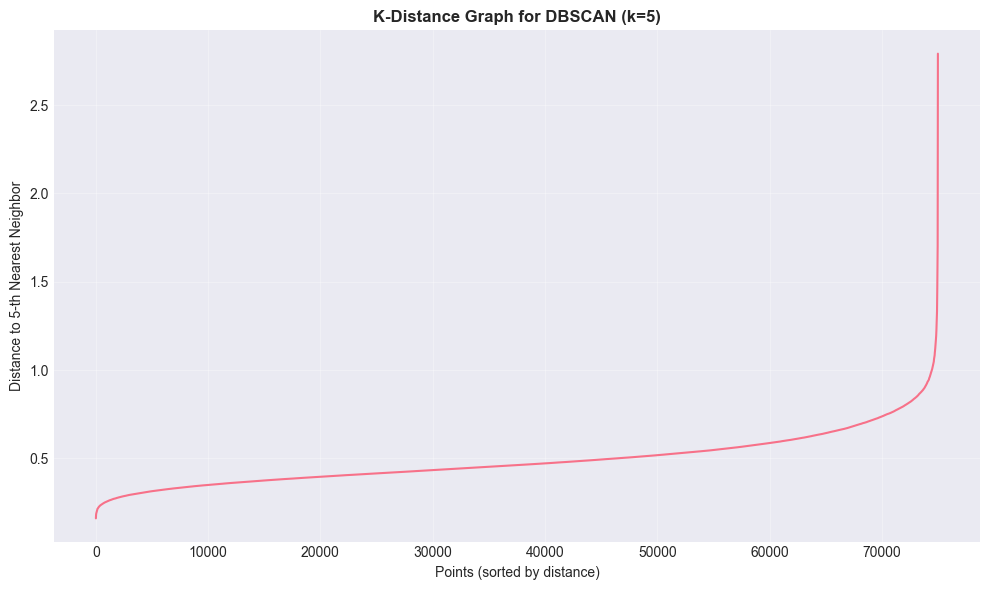

Suggested eps (90th percentile): 0.68

DBSCAN Results (eps=0.68, min_samples=8):
 Clusters found: 21
 Noise points: 5667 (7.6%)
 Silhouette Score: -0.2718

--------------------------------------------------------------------------------
VISUALISATION 3D - DBSCAN Clustering
--------------------------------------------------------------------------------


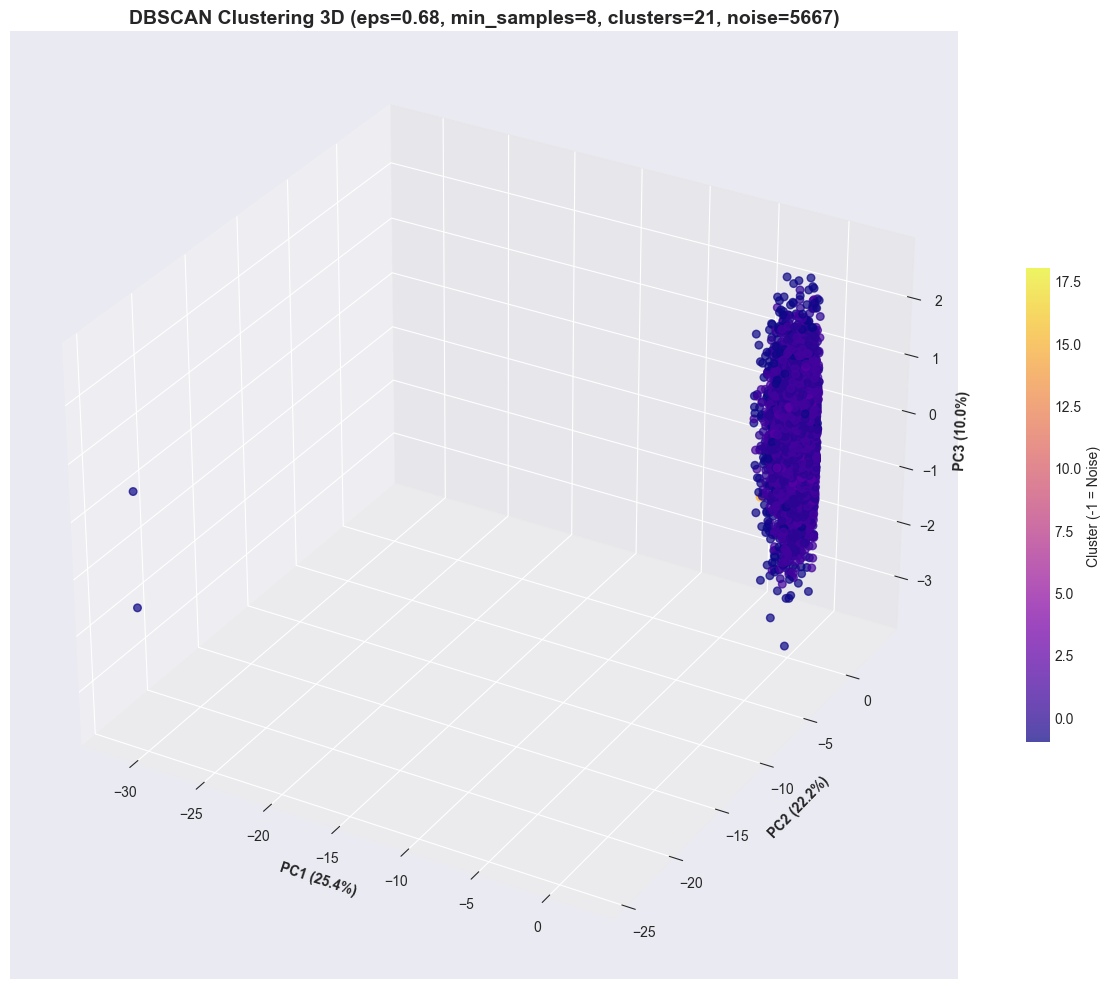

In [11]:
# Find optimal eps using k-distance graph
k_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=k_neighbors)
nbrs.fit(Z)
distances, indices = nbrs.kneighbors(Z)
distances = np.sort(distances[:, k_neighbors-1])

# Plot k-distance graph
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(distances)
ax.set_xlabel('Points (sorted by distance)')
ax.set_ylabel(f'Distance to {k_neighbors}-th Nearest Neighbor')
ax.set_title(f'K-Distance Graph for DBSCAN (k={k_neighbors})', fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Suggest eps from elbow
eps_suggestion = np.percentile(distances, 90)
print(f"Suggested eps (90th percentile): {eps_suggestion:.2f}")

# Try DBSCAN with suggested eps
eps = eps_suggestion
min_samples = 8

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(Z)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\nDBSCAN Results (eps={eps:.2f}, min_samples={min_samples}):")
print(f" Clusters found: {n_clusters_dbscan}")
print(f" Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

# Calculate silhouette if we have at least 2 clusters
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if mask.sum() > 0:
        dbscan_silhouette = silhouette_score(Z[mask], dbscan_labels[mask])
        print(f" Silhouette Score: {dbscan_silhouette:.4f}")
    else:
        print(" Silhouette Score: N/A (< 2 clusters)")

# NOUVEAU: Visualize DBSCAN clusters en 3D
print("\n" + "-" * 80)
print("VISUALISATION 3D - DBSCAN Clustering")
print("-" * 80)

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

sample_indices = np.random.choice(len(Z), min(5000, len(Z)), replace=False)
scatter = ax.scatter(Z[sample_indices, 0],
                     Z[sample_indices, 1],
                     Z[sample_indices, 2],
                     c=dbscan_labels[sample_indices],
                     cmap='plasma',
                     s=30,
                     alpha=0.7)

ax.set_xlabel(f'PC1 ({pca_final.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_final.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_final.explained_variance_ratio_[2]*100:.1f}%)', fontweight='bold')
ax.set_title(f'DBSCAN Clustering 3D (eps={eps:.2f}, min_samples={min_samples}, '
             f'clusters={n_clusters_dbscan}, noise={n_noise})',
             fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='Cluster (-1 = Noise)', shrink=0.5)
plt.tight_layout()
plt.show()


## 7.3: K-MEANS VS DBSCAN COMPARISON 

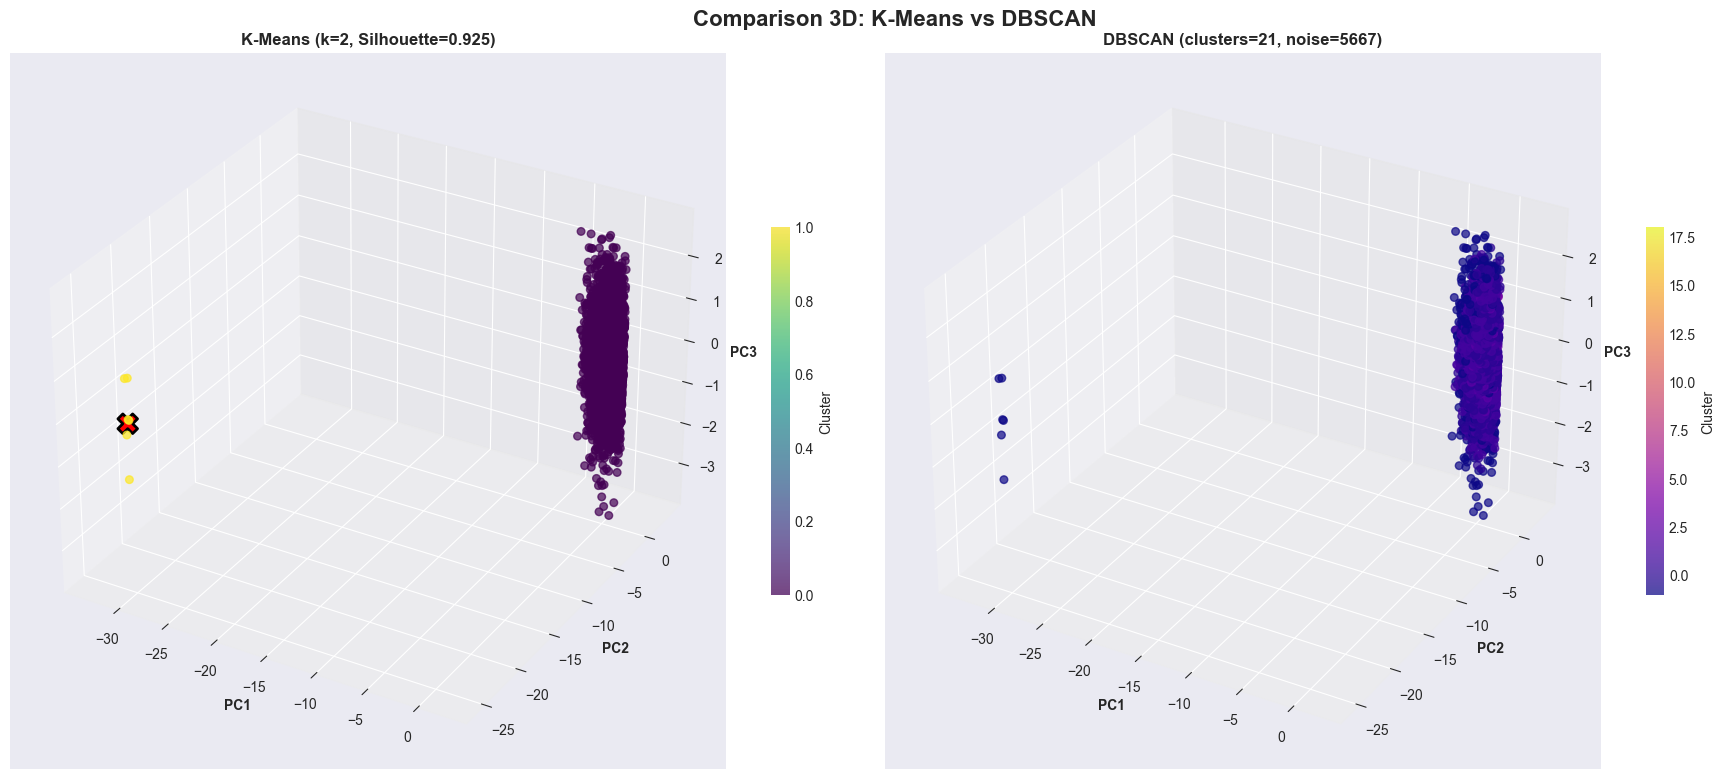

In [12]:
fig = plt.figure(figsize=(18, 8))

# K-Means 3D
ax1 = fig.add_subplot(121, projection='3d')
sample_indices = np.random.choice(len(Z), min(5000, len(Z)), replace=False)
scatter1 = ax1.scatter(Z[sample_indices, 0],
                       Z[sample_indices, 1],
                       Z[sample_indices, 2],
                       c=kmeans_labels[sample_indices],
                       cmap='viridis',
                       s=30,
                       alpha=0.7)
ax1.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
            c='red', s=200, marker='X',
            edgecolors='black', linewidths=2)
ax1.set_xlabel(f'PC1', fontweight='bold')
ax1.set_ylabel(f'PC2', fontweight='bold')
ax1.set_zlabel(f'PC3', fontweight='bold')
ax1.set_title(f'K-Means (k={best_k}, Silhouette={best_silhouette:.3f})', fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster', shrink=0.5)

# DBSCAN 3D
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(Z[sample_indices, 0],
                       Z[sample_indices, 1],
                       Z[sample_indices, 2],
                       c=dbscan_labels[sample_indices],
                       cmap='plasma',
                       s=30,
                       alpha=0.7)
ax2.set_xlabel(f'PC1', fontweight='bold')
ax2.set_ylabel(f'PC2', fontweight='bold')
ax2.set_zlabel(f'PC3', fontweight='bold')
ax2.set_title(f'DBSCAN (clusters={n_clusters_dbscan}, noise={n_noise})', fontweight='bold')
plt.colorbar(scatter2, ax=ax2, label='Cluster', shrink=0.5)

plt.suptitle('Comparison 3D: K-Means vs DBSCAN', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# 8) COMBINAISON CLUSTERING + CLASSIFICATION (NOUVEAU)

In [13]:
print("""
OBJECTIF: Utiliser les labels de clustering (K-Means et DBSCAN) comme features
supplémentaires pour améliorer les performances de classification.

Cette approche permet de capturer les structures latentes découvertes par le
clustering pour enrichir le modèle de classification.
""")

# Ajouter les labels de clustering aux features
if 'Risk_Level' in df.columns:
    # Create augmented feature matrix
    X_with_clusters = np.column_stack([X_preprocessed, kmeans_labels, dbscan_labels])

    print(f"\nAugmented features created:")
    print(f" Original features: {X_preprocessed.shape[1]}")
    print(f" + K-Means cluster labels: 1")
    print(f" + DBSCAN cluster labels: 1")
    print(f" Total features: {X_with_clusters.shape[1]}")

    # Prepare target
    y = df['Risk_Level'].copy()
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        target_classes = le_target.classes_
    else:
        y_encoded = y.values
        target_classes = np.unique(y_encoded)

    # Split data with augmented features
    X_train_clust, X_test_clust, y_train_clust, y_test_clust = train_test_split(
        X_with_clusters, y_encoded,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_encoded
    )

    print(f"\nTrain set: {X_train_clust.shape[0]:,} samples")
    print(f"Test set: {X_test_clust.shape[0]:,} samples")



OBJECTIF: Utiliser les labels de clustering (K-Means et DBSCAN) comme features
supplémentaires pour améliorer les performances de classification.

Cette approche permet de capturer les structures latentes découvertes par le
clustering pour enrichir le modèle de classification.


Augmented features created:
 Original features: 22
 + K-Means cluster labels: 1
 + DBSCAN cluster labels: 1
 Total features: 24

Train set: 60,000 samples
Test set: 15,000 samples


# 9) CLASSIFICATION AVEC GRIDSEARCHCV (MODIFIÉ)

In [14]:
# Check if we have Risk_Level as target
if 'Risk_Level' not in df.columns:
    print("\nWarning: Risk_Level column not found. Skipping classification...")
else:
    # Prepare target variable
    y = df['Risk_Level'].copy()

    # Encode target if it's categorical
    if y.dtype == 'object':
        le_target = LabelEncoder()
        y_encoded = le_target.fit_transform(y)
        target_classes = le_target.classes_
    else:
        y_encoded = y.values
        target_classes = np.unique(y_encoded)

    print(f"\nTarget variable: Risk_Level")
    print(f"Classes: {target_classes}")
    print(f"Distribution:")
    print(pd.Series(y).value_counts().sort_index())

    # Split data (WITHOUT cluster features first)
    X_train, X_test, y_train, y_test = train_test_split(
        X_preprocessed, y_encoded,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y_encoded
    )

    print(f"\nTrain set: {X_train.shape[0]:,} samples")
    print(f"Test set: {X_test.shape[0]:,} samples")

    # Store model results
    model_results = {}

    # Cross-validation strategy
    cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



Target variable: Risk_Level
Classes: ['High' 'Low' 'Medium']
Distribution:
Risk_Level
High       4048
Low       55154
Medium    15798
Name: count, dtype: int64

Train set: 60,000 samples
Test set: 15,000 samples


## 9.1: DECISION TREE AVEC GRIDSEARCHCV (MODIFIÉ)

Lancement GridSearchCV pour Decision Tree...
Combinaisons à tester: 500
Fitting 5 folds for each of 500 candidates, totalling 2500 fits

Meilleurs hyperparamètres Decision Tree:
 criterion: gini
 max_depth: 10
 min_samples_leaf: 2
 min_samples_split: 5
 splitter: best
 Best CV Score (F1): 0.9527

Decision Tree Results (Test Set):
 Accuracy: 0.9516
 F1-Score (weighted): 0.9521

Classification Report:
              precision    recall  f1-score   support

        High       0.86      0.87      0.87       809
         Low       0.98      0.97      0.98     11031
      Medium       0.87      0.91      0.89      3160

    accuracy                           0.95     15000
   macro avg       0.90      0.92      0.91     15000
weighted avg       0.95      0.95      0.95     15000



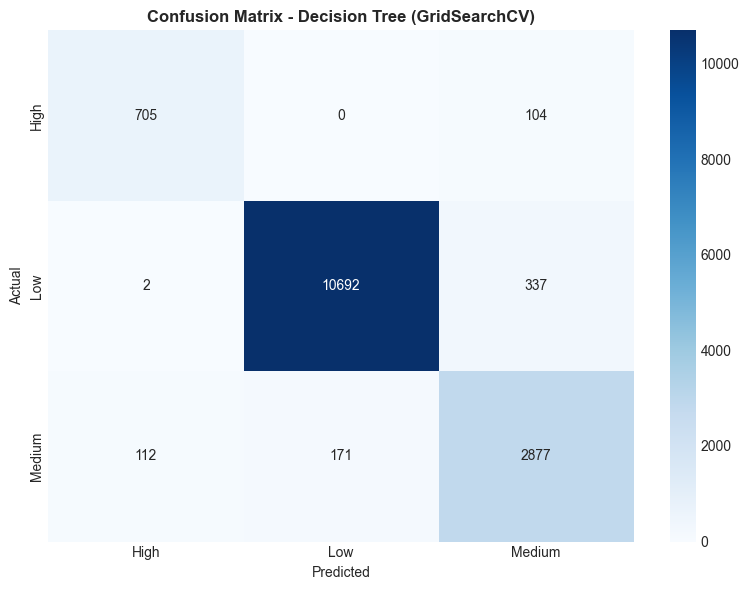

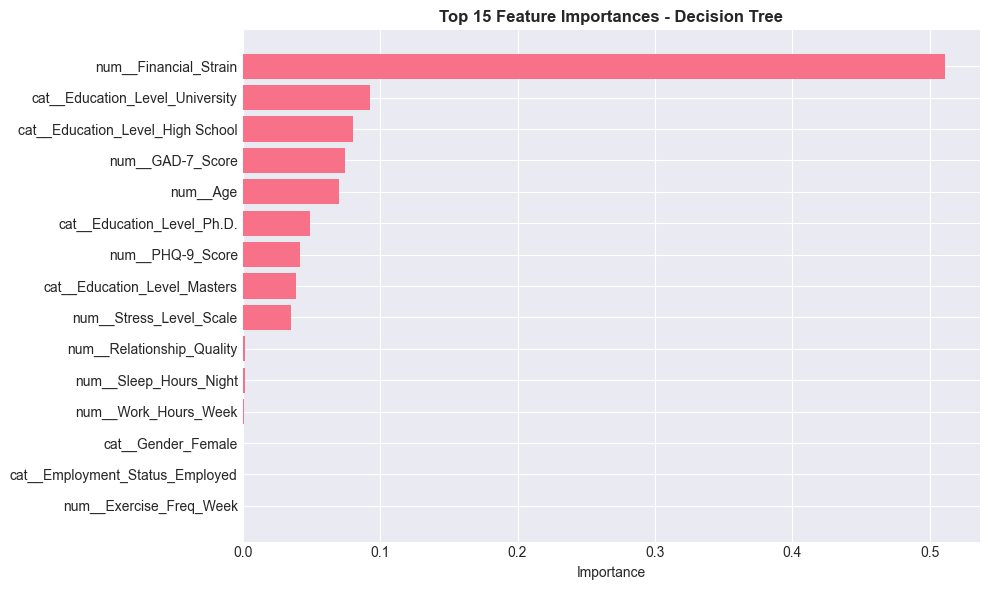

In [15]:
dt_param_grid = {
        'max_depth': [5, 10, 15, 20, None],
        'min_samples_split': [5, 10, 20, 30, 50],
        'min_samples_leaf': [2, 5, 10, 15, 20],
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random']
    }

dt_base = DecisionTreeClassifier(random_state=RANDOM_STATE)

print("Lancement GridSearchCV pour Decision Tree...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in dt_param_grid.values()])}")

dt_grid = GridSearchCV(
    dt_base,
    dt_param_grid,
    cv=cv_folds,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_train, y_train)

print(f"\nMeilleurs hyperparamètres Decision Tree:")
for param, value in dt_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (F1): {dt_grid.best_score_:.4f}")

dt_best = dt_grid.best_estimator_
dt_pred = dt_best.predict(X_test)

dt_accuracy = accuracy_score(y_test, dt_pred)
dt_f1 = f1_score(y_test, dt_pred, average='weighted')

print(f"\nDecision Tree Results (Test Set):")
print(f" Accuracy: {dt_accuracy:.4f}")
print(f" F1-Score (weighted): {dt_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dt_pred, target_names=[str(c) for c in target_classes]))

model_results['Decision Tree'] = {
    'Accuracy': dt_accuracy,
    'F1-Score': dt_f1,
    'Model': dt_best,
    'Best_Params': dt_grid.best_params_
}

# Confusion Matrix
cm_dt = confusion_matrix(y_test, dt_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - Decision Tree (GridSearchCV)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance_dt = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_best.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_dt['Feature'], feature_importance_dt['Importance'])
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - Decision Tree', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 9.2 RANDOM FOREST AVEC GRIDSEARCHCV (MODIFIÉ)

Lancement GridSearchCV pour Random Forest...
Combinaisons à tester: 72
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Meilleurs hyperparamètres Random Forest:
 bootstrap: True
 max_depth: None
 max_features: sqrt
 min_samples_leaf: 2
 min_samples_split: 5
 n_estimators: 500
 Best CV Score (F1): 0.9607

Random Forest Results (Test Set):
 Accuracy: 0.9583
 F1-Score (weighted): 0.9586

Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.88      0.88       809
         Low       0.99      0.98      0.98     11031
      Medium       0.89      0.92      0.90      3160

    accuracy                           0.96     15000
   macro avg       0.92      0.92      0.92     15000
weighted avg       0.96      0.96      0.96     15000



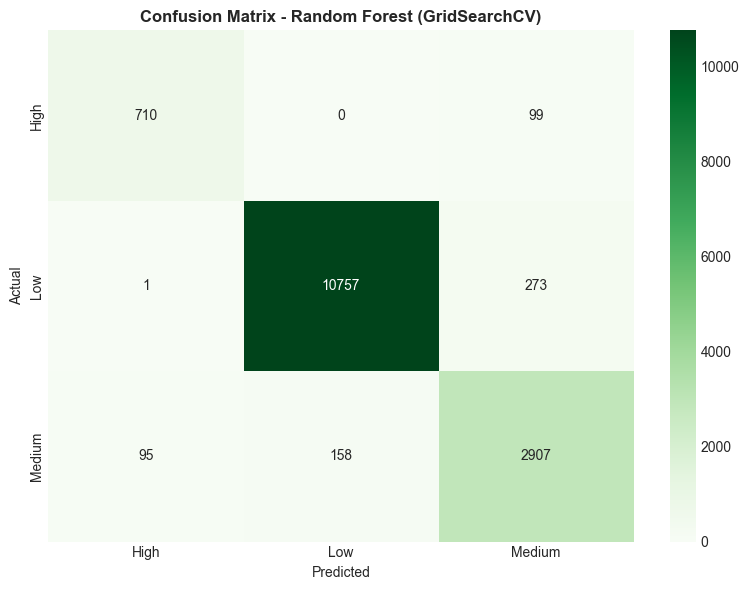

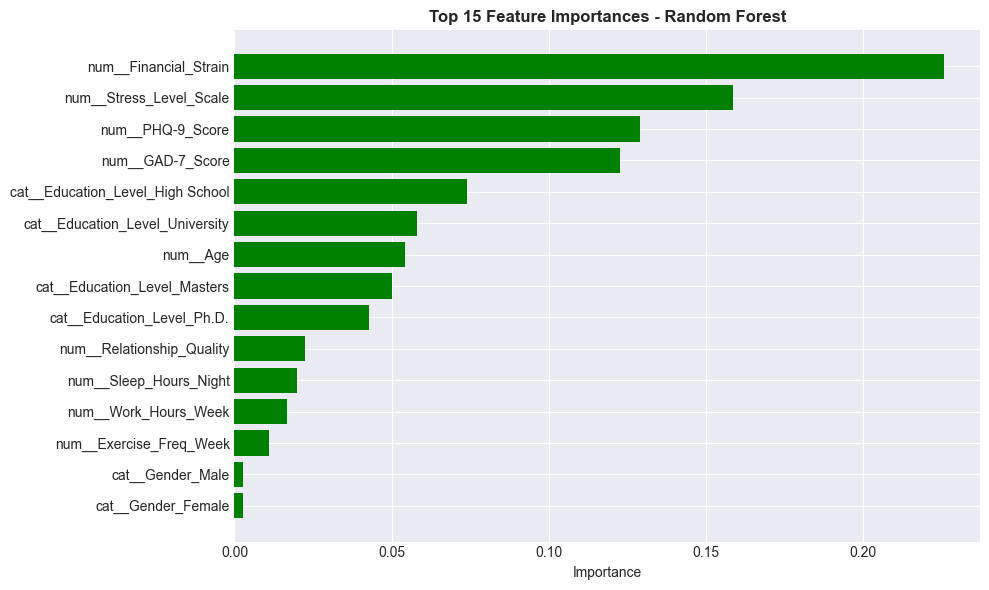

In [16]:
# rf_param_grid = {
#         'n_estimators': [100, 200, 300, 400, 500],
#         'max_depth': [10, 15, 20, 25, None],
#         'min_samples_split': [5, 10, 15, 20, 30],
#         'min_samples_leaf': [2, 5, 10, 15],
#         'max_features': ['sqrt', 'log2', None],
#         'bootstrap': [True, False]
#     }

rf_param_grid = {
    'n_estimators': [200, 300, 500],           # seulement 3 valeurs
    'max_depth': [15, 20, None],               # 3 valeurs
    'min_samples_split': [5, 10],              # 2 valeurs
    'min_samples_leaf': [2, 5],                # 2 valeurs
    'max_features': ['sqrt', 'log2'],          # 2 valeurs
    'bootstrap': [True]                        # fixe à True (meilleur en général)
}

rf_base = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)

print("Lancement GridSearchCV pour Random Forest...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in rf_param_grid.values()])}")

rf_grid = GridSearchCV(
    rf_base,
    rf_param_grid,
    cv=cv_folds,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
rf_grid.fit(X_train, y_train)

print(f"\nMeilleurs hyperparamètres Random Forest:")
for param, value in rf_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (F1): {rf_grid.best_score_:.4f}")

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"\nRandom Forest Results (Test Set):")
print(f" Accuracy: {rf_accuracy:.4f}")
print(f" F1-Score (weighted): {rf_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=[str(c) for c in target_classes]))

model_results['Random Forest'] = {
    'Accuracy': rf_accuracy,
    'F1-Score': rf_f1,
    'Model': rf_best,
    'Best_Params': rf_grid.best_params_
}

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - Random Forest (GridSearchCV)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_best.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], color='green')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - Random Forest', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 9.3: SVM AVEC GRIDSEARCHCV (MODIFIÉ)

Using stratified subset (10,000 samples) for SVM training due to computational cost...
Lancement GridSearchCV pour SVM...
Combinaisons à tester: 9
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Meilleurs hyperparamètres SVM:
 C: 100
 gamma: 0.01
 kernel: rbf
 Best CV Score (F1): 0.9489

SVM Results (Test Set):
 Accuracy: 0.9517
 F1-Score (weighted): 0.9516

Classification Report:
              precision    recall  f1-score   support

        High       0.86      0.86      0.86       809
         Low       0.98      0.98      0.98     11031
      Medium       0.89      0.88      0.89      3160

    accuracy                           0.95     15000
   macro avg       0.91      0.91      0.91     15000
weighted avg       0.95      0.95      0.95     15000



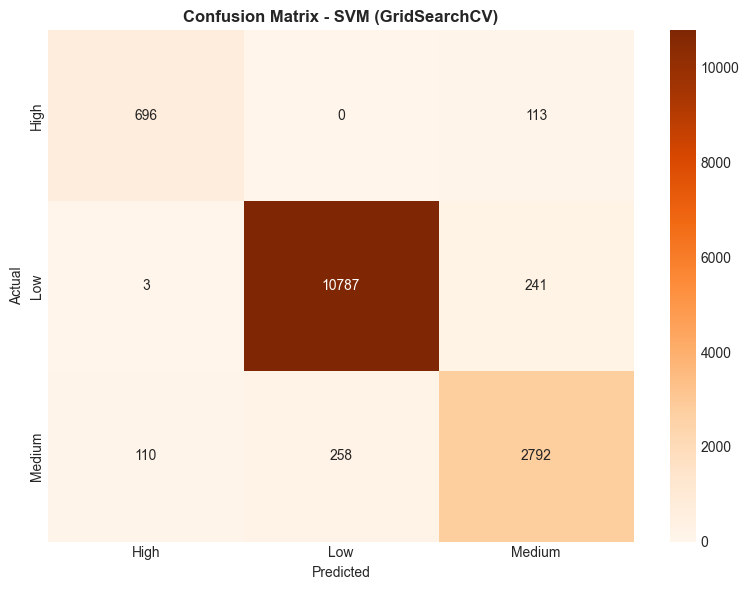

In [17]:
if len(X_train) > 10000:
    print("Using stratified subset (10,000 samples) for SVM training due to computational cost...")
    X_train_svm, _, y_train_svm, _ = train_test_split(
        X_train, y_train,
        train_size=10000,
        random_state=RANDOM_STATE,
        stratify=y_train
    )
else:
    X_train_svm = X_train
    y_train_svm = y_train

# svm_param_grid = {
#     'C': [0.1, 1, 10, 50, 100],
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }
svm_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf']
}

svm_base = SVC(random_state=RANDOM_STATE)

print("Lancement GridSearchCV pour SVM...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in svm_param_grid.values()])}")

svm_grid = GridSearchCV(
    svm_base,
    svm_param_grid,
    cv=3,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
svm_grid.fit(X_train_svm, y_train_svm)

print(f"\nMeilleurs hyperparamètres SVM:")
for param, value in svm_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (F1): {svm_grid.best_score_:.4f}")

svm_best = svm_grid.best_estimator_
svm_pred = svm_best.predict(X_test)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print(f"\nSVM Results (Test Set):")
print(f" Accuracy: {svm_accuracy:.4f}")
print(f" F1-Score (weighted): {svm_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, svm_pred, target_names=[str(c) for c in target_classes]))

model_results['SVM'] = {
    'Accuracy': svm_accuracy,
    'F1-Score': svm_f1,
    'Model': svm_best,
    'Best_Params': svm_grid.best_params_
}

# Confusion Matrix
cm_svm = confusion_matrix(y_test, svm_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - SVM (GridSearchCV)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()


## 9.4: XGBOOST AVEC GRIDSEARCHCV (MODIFIÉ)

Lancement GridSearchCV pour XGBoost...
Combinaisons à tester: 96
Fitting 5 folds for each of 96 candidates, totalling 480 fits

Meilleurs hyperparamètres XGBoost:
 colsample_bytree: 1.0
 gamma: 0
 learning_rate: 0.05
 max_depth: 9
 n_estimators: 200
 subsample: 0.8
 Best CV Score (F1): 0.9639

XGBoost Results (Test Set):
 Accuracy: 0.9615
 F1-Score (weighted): 0.9619

Classification Report:
              precision    recall  f1-score   support

        High       0.88      0.90      0.89       809
         Low       0.99      0.98      0.98     11031
      Medium       0.89      0.93      0.91      3160

    accuracy                           0.96     15000
   macro avg       0.92      0.93      0.93     15000
weighted avg       0.96      0.96      0.96     15000



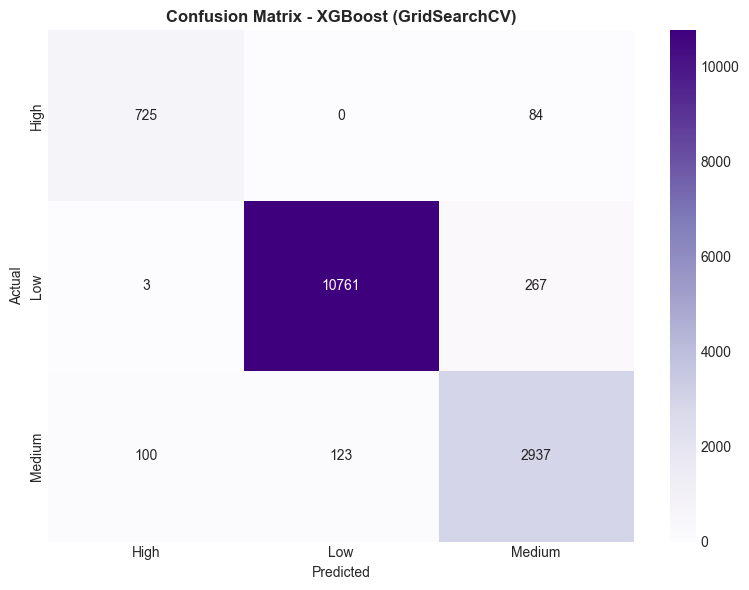

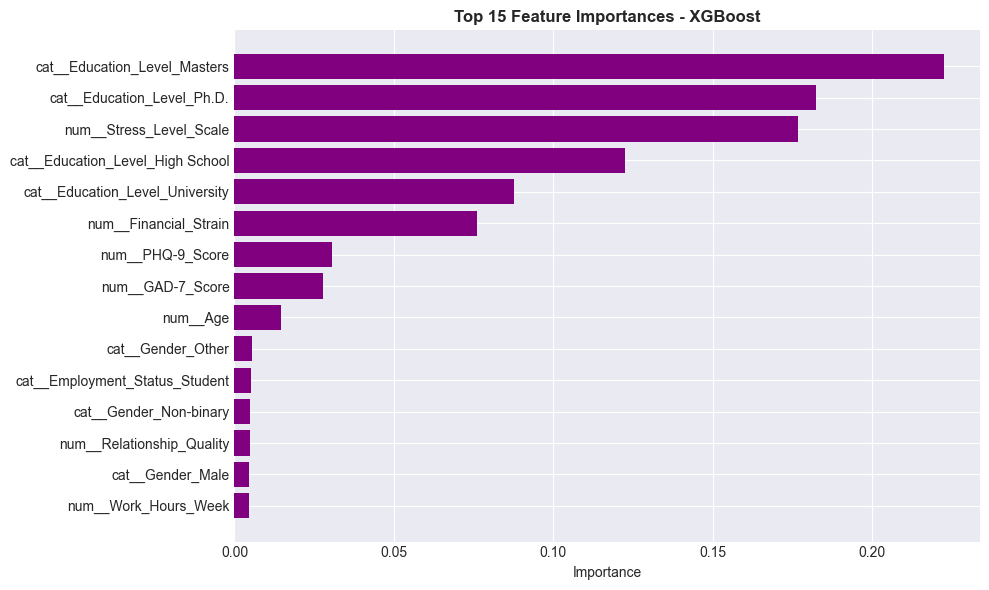

In [18]:
# xgb_param_grid = {
#         'n_estimators': [100, 200, 300, 400, 500],
#         'max_depth': [3, 5, 7, 9, 12],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#         'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.5, 1.0],
#         'min_child_weight': [1, 3, 5, 7]
#     }

xgb_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7, 9],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

xgb_base = XGBClassifier(
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='mlogloss'
)

print("Lancement GridSearchCV pour XGBoost...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in xgb_param_grid.values()])}")

xgb_grid = GridSearchCV(
    xgb_base,
    xgb_param_grid,
    cv=cv_folds,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)
xgb_grid.fit(X_train, y_train)

print(f"\nMeilleurs hyperparamètres XGBoost:")
for param, value in xgb_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (F1): {xgb_grid.best_score_:.4f}")

xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')

print(f"\nXGBoost Results (Test Set):")
print(f" Accuracy: {xgb_accuracy:.4f}")
print(f" F1-Score (weighted): {xgb_f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=[str(c) for c in target_classes]))

model_results['XGBoost'] = {
    'Accuracy': xgb_accuracy,
    'F1-Score': xgb_f1,
    'Model': xgb_best,
    'Best_Params': xgb_grid.best_params_
}

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Purples',
            xticklabels=target_classes, yticklabels=target_classes, ax=ax)
ax.set_title('Confusion Matrix - XGBoost (GridSearchCV)', fontweight='bold')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_best.feature_importances_
}).sort_values('Importance', ascending=False).head(15)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], color='purple')
ax.set_xlabel('Importance')
ax.set_title('Top 15 Feature Importances - XGBoost', fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 9.5: CLASSIFICATION AVEC FEATURES DE CLUSTERING (NOUVEAU)

In [29]:
rf_cluster = RandomForestClassifier(
        **rf_grid.best_params_,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

rf_cluster.fit(X_train_clust, y_train_clust)
rf_cluster_pred = rf_cluster.predict(X_test_clust)

rf_cluster_accuracy = accuracy_score(y_test_clust, rf_cluster_pred)
rf_cluster_f1 = f1_score(y_test_clust, rf_cluster_pred, average='weighted')

print(f"\nRandom Forest + Clustering Results:")
print(f" Accuracy: {rf_cluster_accuracy:.4f}")
print(f" F1-Score (weighted): {rf_cluster_f1:.4f}")
print(f"\nComparaison avec RF standard:")
print(f" RF standard: Accuracy={rf_accuracy:.4f}, F1={rf_f1:.4f}")
print(f" RF + Clustering: Accuracy={rf_cluster_accuracy:.4f}, F1={rf_cluster_f1:.4f}")
print(f" Amélioration Accuracy: {(rf_cluster_accuracy - rf_accuracy)*100:.2f}%")
print(f" Amélioration F1: {(rf_cluster_f1 - rf_f1)*100:.2f}%")

model_results['RF + Clustering'] = {
    'Accuracy': rf_cluster_accuracy,
    'F1-Score': rf_cluster_f1,
    'Model': rf_cluster,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


Random Forest + Clustering Results:
 Accuracy: 0.9574
 F1-Score (weighted): 0.9577

Comparaison avec RF standard:
 RF standard: Accuracy=0.9583, F1=0.9586
 RF + Clustering: Accuracy=0.9574, F1=0.9577
 Amélioration Accuracy: -0.09%
 Amélioration F1: -0.09%


In [30]:
xgb_clust = XGBClassifier(
   **xgb_grid.best_params_,
    random_state=RANDOM_STATE,
    eval_metric="mlogloss"
)
n_clusters_used = kmeans.n_clusters  

xgb_clust.fit(X_train_clust, y_train_clust)
xgb_pred = xgb_clust.predict(X_test_clust)

xgb_cluster_accuracy = accuracy_score(y_test_clust, xgb_pred)
xgb_cluster_f1 = f1_score(y_test_clust, xgb_pred, average='weighted')

print(f"\nXGBoost + Clustering Results:")
print(f" Accuracy: {xgb_cluster_accuracy:.4f}")
print(f" F1-Score (weighted): {xgb_cluster_f1:.4f}")
print(f"\nComparaison avec XGBoost standard:")
print(f" XGBoost standard: Accuracy={xgb_accuracy:.4f}, F1={xgb_f1:.4f}")
print(f" XGBoost + Clustering: Accuracy={xgb_cluster_accuracy:.4f}, F1={xgb_cluster_f1:.4f}")
print(f" Amélioration Accuracy: {(xgb_cluster_accuracy - xgb_accuracy)*100:.2f}%")
print(f" Amélioration F1: {(xgb_cluster_f1 - xgb_f1)*100:.2f}%")

model_results['XGBoost + Clustering'] = {
    'Accuracy': xgb_cluster_accuracy,
    'F1-Score': xgb_cluster_f1,
    'Model': xgb_clust,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}



XGBoost + Clustering Results:
 Accuracy: 0.9616
 F1-Score (weighted): 0.9620

Comparaison avec XGBoost standard:
 XGBoost standard: Accuracy=0.9615, F1=0.9619
 XGBoost + Clustering: Accuracy=0.9616, F1=0.9620
 Amélioration Accuracy: 0.01%
 Amélioration F1: 0.01%


In [31]:
svm_cluster = SVC(
    **svm_grid.best_params_,
    probability=True
)

svm_cluster.fit(X_train_clust, y_train_clust)
svm_cluster_pred = svm_cluster.predict(X_test_clust)
svm_cluster_accuracy = accuracy_score(y_test_clust, svm_cluster_pred)
svm_cluster_f1 = f1_score(y_test_clust, svm_cluster_pred, average='weighted')

print(f"\nSVM + Clustering Results:")
print(f" Accuracy: {svm_cluster_accuracy:.4f}")
print(f" F1-Score (weighted): {svm_cluster_f1:.4f}")
print(f"\nComparaison avec SVM standard:")
print(f" SVM standard: Accuracy={svm_accuracy:.4f}, F1={svm_f1:.4f}")
print(f" SVM + Clustering: Accuracy={svm_cluster_accuracy:.4f}, F1={svm_cluster_f1:.4f}")
print(f" Amélioration Accuracy: {(svm_cluster_accuracy - svm_accuracy)*100:.2f}%")
print(f" Amélioration F1: {(svm_cluster_f1 - svm_f1)*100:.2f}%")
model_results['SVM + Clustering'] = {
    'Accuracy': svm_cluster_accuracy,
    'F1-Score': svm_cluster_f1,
    'Model': svm_cluster,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


SVM + Clustering Results:
 Accuracy: 0.9597
 F1-Score (weighted): 0.9599

Comparaison avec SVM standard:
 SVM standard: Accuracy=0.9517, F1=0.9516
 SVM + Clustering: Accuracy=0.9597, F1=0.9599
 Amélioration Accuracy: 0.81%
 Amélioration F1: 0.83%


In [ ]:
dt_grid = DecisionTreeClassifier(
    **dt_grid.best_params_,
    random_state=RANDOM_STATE
)
dt_grid.fit(X_train_clust, y_train_clust)
dt_cluster_pred = dt_grid.predict(X_test_clust)
dt_cluster_accuracy = accuracy_score(y_test_clust, dt_cluster_pred)
dt_cluster_f1 = f1_score(y_test_clust, dt_cluster_pred, average='weighted')
print(f"\nDecision Tree + Clustering Results:")
print(f" Accuracy: {dt_cluster_accuracy:.4f}")
print(f" F1-Score (weighted): {dt_cluster_f1:.4f}")
print(f"\nComparaison avec Decision Tree standard:")
print(f" Decision Tree standard: Accuracy={dt_accuracy:.4f}, F1={dt_f1:.4f}")
print(f" Decision Tree + Clustering: Accuracy={dt_cluster_accuracy:.4f}, F1={dt_cluster_f1:.4f}")
print(f" Amélioration Accuracy: {(dt_cluster_accuracy - dt_accuracy)*100:.2f}%")
print(f" Amélioration F1: {(dt_cluster_f1 - dt_f1)*100:.2f}%")
model_results['Decision Tree + Clustering'] = {
    'Accuracy': dt_cluster_accuracy,
    'F1-Score': dt_cluster_f1,
    'Model': dt_grid,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


Decision Tree + Clustering Results:
 Accuracy: 0.9515
 F1-Score (weighted): 0.9520

Comparaison avec Decision Tree standard:
 Decision Tree standard: Accuracy=0.9516, F1=0.9521
 Decision Tree + Clustering: Accuracy=0.9515, F1=0.9520
 Amélioration Accuracy: -0.01%
 Amélioration F1: -0.01%


## 9.6: MODEL COMPARISON


Model Performance Summary:
                     Model  Accuracy  F1-Score
      XGBoost + Clustering      0.96      0.96
                   XGBoost      0.96      0.96
          SVM + Clustering      0.96      0.96
             Random Forest      0.96      0.96
           RF + Clustering      0.96      0.96
                       SVM      0.95      0.95
             Decision Tree      0.95      0.95
Decision Tree + Clustering      0.95      0.95


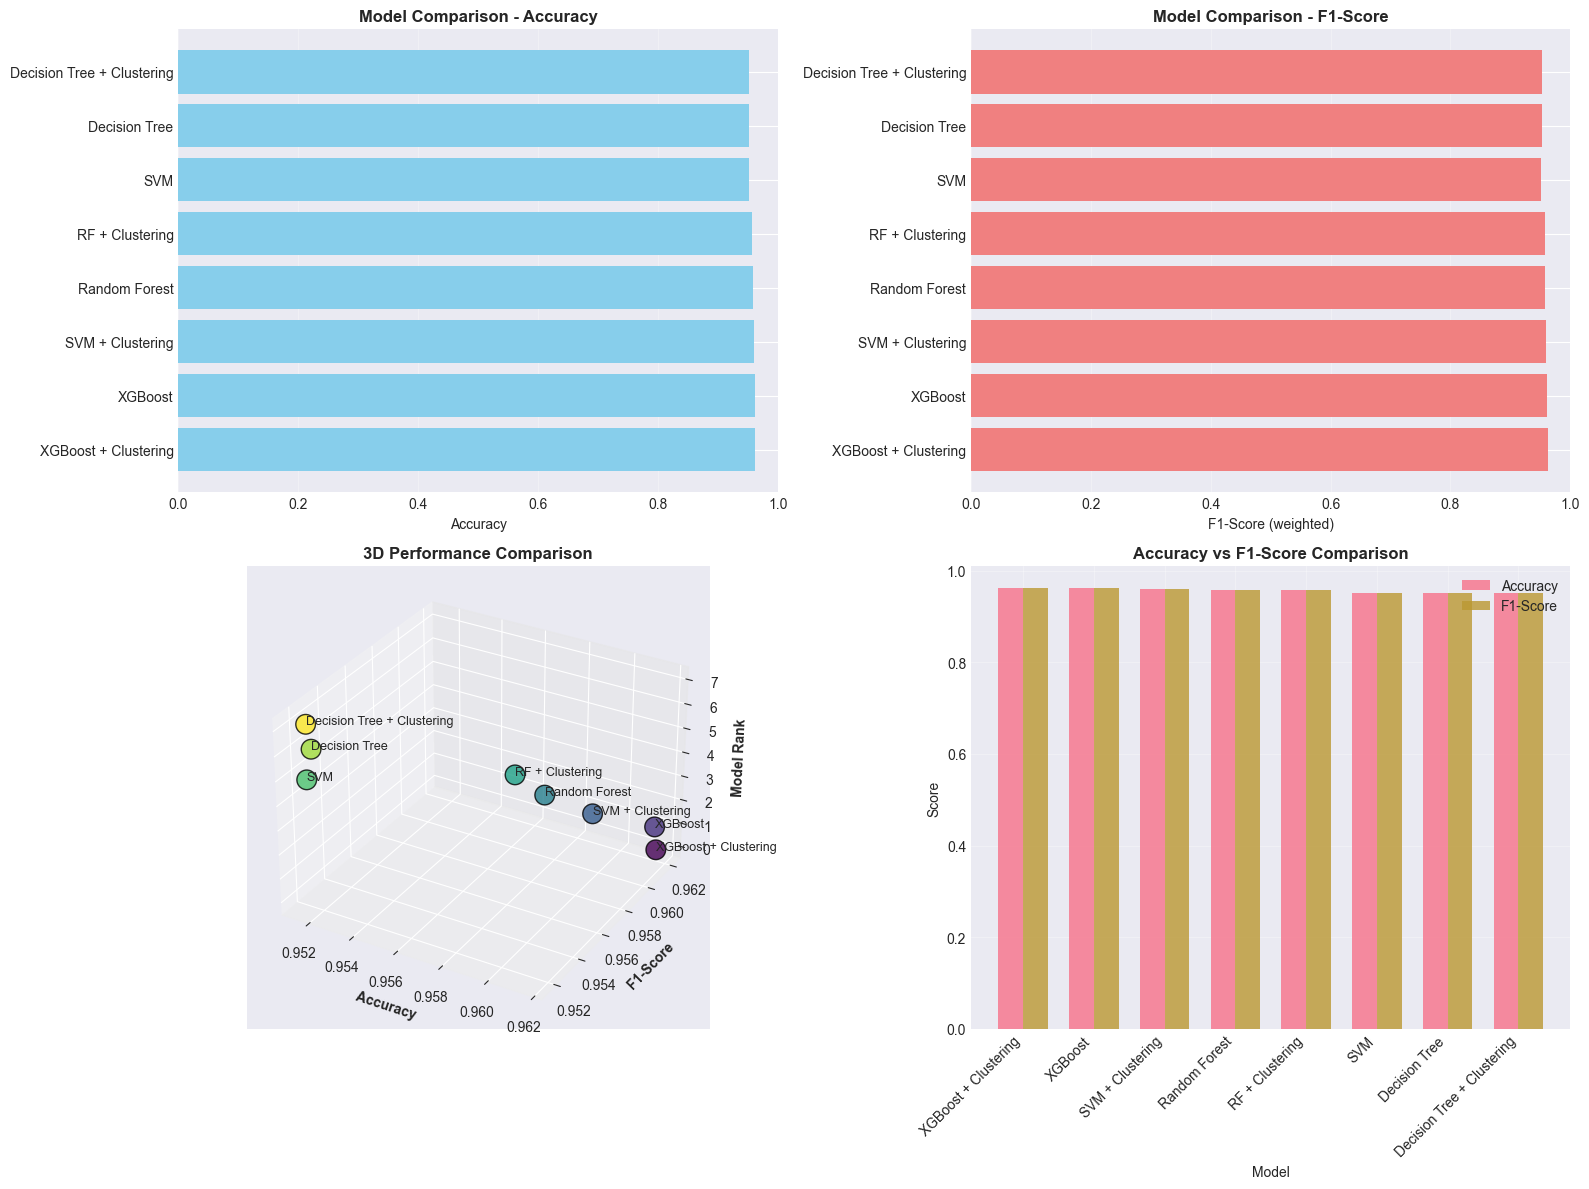


Best Model: XGBoost + Clustering (Accuracy: 0.9616)

BEST HYPERPARAMETERS FOR EACH MODEL:

Decision Tree:
 criterion: gini
 max_depth: 10
 min_samples_leaf: 2
 min_samples_split: 5
 splitter: best

Random Forest:
 bootstrap: True
 max_depth: None
 max_features: sqrt
 min_samples_leaf: 2
 min_samples_split: 5
 n_estimators: 500

SVM:
 C: 100
 gamma: 0.01
 kernel: rbf

XGBoost:
 colsample_bytree: 1.0
 gamma: 0
 learning_rate: 0.05
 max_depth: 9
 n_estimators: 200
 subsample: 0.8

DETAILED METRICS FOR EACH MODEL

Model: XGBoost + Clustering
  → Accuracy : 0.9616
  → F1-Score : 0.9620
  → Clustering Used : NO

Model: XGBoost
  → Accuracy : 0.9615
  → F1-Score : 0.9619
  → Clustering Used : NO

Model: SVM + Clustering
  → Accuracy : 0.9597
  → F1-Score : 0.9599
  → Clustering Used : NO

Model: Random Forest
  → Accuracy : 0.9583
  → F1-Score : 0.9586
  → Clustering Used : NO

Model: RF + Clustering
  → Accuracy : 0.9574
  → F1-Score : 0.9577
  → Clustering Used : NO

Model: SVM
  → Accurac

In [ ]:
comparison_df = pd.DataFrame({
        'Model': list(model_results.keys()),
        'Accuracy': [model_results[m]['Accuracy'] for m in model_results],
        'F1-Score': [model_results[m]['F1-Score'] for m in model_results]
    }).sort_values('Accuracy', ascending=False)

print("\nModel Performance Summary:")
print(comparison_df)

# NOUVEAU: Visualization 3D des performances
fig = plt.figure(figsize=(16, 12))

# Subplot 1: Bar comparison
ax1 = fig.add_subplot(2, 2, 1)
ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color='skyblue')
ax1.set_xlabel('Accuracy')
ax1.set_title('Model Comparison - Accuracy', fontweight='bold')
ax1.set_xlim(0, 1)
ax1.grid(True, axis='x', alpha=0.3)

ax2 = fig.add_subplot(2, 2, 2)
ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color='lightcoral')
ax2.set_xlabel('F1-Score (weighted)')
ax2.set_title('Model Comparison - F1-Score', fontweight='bold')
ax2.set_xlim(0, 1)
ax2.grid(True, axis='x', alpha=0.3)

# Subplot 3: 3D scatter
ax3 = fig.add_subplot(2, 2, 3, projection='3d')
x_vals = comparison_df['Accuracy'].values
y_vals = comparison_df['F1-Score'].values
z_vals = np.arange(len(comparison_df))

colors = plt.cm.viridis(np.linspace(0, 1, len(comparison_df)))
ax3.scatter(x_vals, y_vals, z_vals, c=colors, s=200, alpha=0.8, edgecolors='black')

for i, model in enumerate(comparison_df['Model']):
    ax3.text(x_vals[i], y_vals[i], z_vals[i], model, fontsize=9)

ax3.set_xlabel('Accuracy', fontweight='bold')
ax3.set_ylabel('F1-Score', fontweight='bold')
ax3.set_zlabel('Model Rank', fontweight='bold')
ax3.set_title('3D Performance Comparison', fontweight='bold')

# Subplot 4: Combined metrics
ax4 = fig.add_subplot(2, 2, 4)
x = np.arange(len(comparison_df))
width = 0.35
ax4.bar(x - width/2, comparison_df['Accuracy'], width, label='Accuracy', alpha=0.8)
ax4.bar(x + width/2, comparison_df['F1-Score'], width, label='F1-Score', alpha=0.8)
ax4.set_xlabel('Model')
ax4.set_ylabel('Score')
ax4.set_title('Accuracy vs F1-Score Comparison', fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_acc = comparison_df.iloc[0]['Accuracy']
print(f"\nBest Model: {best_model_name} (Accuracy: {best_model_acc:.4f})")

# Print best hyperparameters for each model
print("\n" + "=" * 80)
print("BEST HYPERPARAMETERS FOR EACH MODEL:")
print("=" * 80)
for model_name in ['Decision Tree', 'Random Forest', 'SVM', 'XGBoost']:
    if model_name in model_results and 'Best_Params' in model_results[model_name]:
        print(f"\n{model_name}:")
        for param, value in model_results[model_name]['Best_Params'].items():
            print(f" {param}: {value}")
print("\n" + "="*80)
print("DETAILED METRICS FOR EACH MODEL")
print("="*80)

for model_name in comparison_df['Model']:

    acc = model_results[model_name]['Accuracy']
    f1 = model_results[model_name]['F1-Score']

    print(f"\nModel: {model_name}")
    print(f"  → Accuracy : {acc:.4f}")
    print(f"  → F1-Score : {f1:.4f}")

    if 'Clustering_Info' in model_results[model_name]:

        cinfo = model_results[model_name]['Clustering_Info']
        print("  → Clustering Used : YES")
        print(f"      KMeans k = {cinfo['KMeans_k']}")
        print(f"      KMeans Silhouette = {cinfo['KMeans_silhouette']:.3f}")
        print(f"      DBSCAN clusters = {cinfo['DBSCAN_clusters']}")
        print(f"      DBSCAN noise points = {cinfo['DBSCAN_noise_points']}")

    else:
        print("  → Clustering Used : NO")



# 10) RÉGRESSION - PRÉDICTION DE VALEURS CONTINUES (NOUVEAU)

In [32]:
from sklearn.model_selection import KFold


print("""
OBJECTIF: Prédire une valeur continue (Stress_Level_Scale) à partir des autres features.

Les modèles de régression utilisés:
- Random Forest Regressor
- XGBoost Regressor
- Gradient Boosting Regressor
- Support Vector Regression (SVR)

Chaque modèle utilise GridSearchCV avec des intervalles d'hyperparamètres.
""")

# Choose continuous target (Stress_Level_Scale)
if 'Stress_Level_Scale' in df.columns:
    # Prepare features and target for regression
    X_reg = df.drop(columns=['Stress_Level_Scale', 'User_ID', 'Risk_Level'], errors='ignore')
    y_reg = df['Stress_Level_Scale'].copy()

    print(f"\nTarget variable: Stress_Level_Scale")
    print(f"Range: [{y_reg.min()}, {y_reg.max()}]")
    print(f"Mean: {y_reg.mean():.2f}")
    print(f"Std: {y_reg.std():.2f}")

    # Identify numerical and categorical columns
    num_features_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features_reg = X_reg.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

    # Create preprocessing pipeline
    num_pipeline_reg = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    cat_pipeline_reg = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor_reg = ColumnTransformer([
        ('num', num_pipeline_reg, num_features_reg),
        ('cat', cat_pipeline_reg, cat_features_reg)
    ])

    # Preprocess features
    X_reg_preprocessed = preprocessor_reg.fit_transform(X_reg)

    # Split data
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        X_reg_preprocessed, y_reg,
        test_size=0.2,
        random_state=RANDOM_STATE
    )

    print(f"\nTrain set: {X_train_reg.shape[0]:,} samples")
    print(f"Test set: {X_test_reg.shape[0]:,} samples")

    # Store regression results
    regression_results = {}

    # Cross-validation strategy for regression
    cv_reg = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)



OBJECTIF: Prédire une valeur continue (Stress_Level_Scale) à partir des autres features.

Les modèles de régression utilisés:
- Random Forest Regressor
- XGBoost Regressor
- Gradient Boosting Regressor
- Support Vector Regression (SVR)

Chaque modèle utilise GridSearchCV avec des intervalles d'hyperparamètres.


Target variable: Stress_Level_Scale
Range: [1.0, 8.0]
Mean: 3.40
Std: 1.57

Train set: 60,000 samples
Test set: 15,000 samples


## 10.1: RANDOM FOREST REGRESSOR

In [33]:
from sklearn.ensemble import RandomForestRegressor


# rfr_param_grid = {
#         'n_estimators': [100, 200, 300, 400],
#         'max_depth': [10, 15, 20, 25, None],
#         'min_samples_split': [5, 10, 15, 20],
#         'min_samples_leaf': [2, 5, 10, 15],
#         'max_features': ['sqrt', 'log2', None]
#     }
rfr_param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [15, 20, None],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 5],
    'max_features': ['sqrt', 'log2']
}

rfr_base = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)

print("Lancement GridSearchCV pour Random Forest Regressor...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in rfr_param_grid.values()])}")

rfr_grid = GridSearchCV(
    rfr_base,
    rfr_param_grid,
    cv=cv_reg,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
rfr_grid.fit(X_train_reg, y_train_reg)

print(f"\nMeilleurs hyperparamètres Random Forest Regressor:")
for param, value in rfr_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (RMSE): {np.sqrt(-rfr_grid.best_score_):.4f}")

rfr_best = rfr_grid.best_estimator_
rfr_pred = rfr_best.predict(X_test_reg)

rfr_mse = mean_squared_error(y_test_reg, rfr_pred)
rfr_rmse = np.sqrt(rfr_mse)
rfr_mae = mean_absolute_error(y_test_reg, rfr_pred)
rfr_r2 = r2_score(y_test_reg, rfr_pred)

print(f"\nRandom Forest Regressor Results:")
print(f" MSE: {rfr_mse:.4f}")
print(f" RMSE: {rfr_rmse:.4f}")
print(f" MAE: {rfr_mae:.4f}")
print(f" R²: {rfr_r2:.4f}")

regression_results['Random Forest'] = {
    'RMSE': rfr_rmse,
    'MAE': rfr_mae,
    'R2': rfr_r2,
    'Model': rfr_best,
    'Best_Params': rfr_grid.best_params_
}

Lancement GridSearchCV pour Random Forest Regressor...
Combinaisons à tester: 72
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Meilleurs hyperparamètres Random Forest Regressor:
 max_depth: None
 max_features: sqrt
 min_samples_leaf: 2
 min_samples_split: 5
 n_estimators: 500
 Best CV Score (RMSE): 0.3905

Random Forest Regressor Results:
 MSE: 0.1493
 RMSE: 0.3864
 MAE: 0.2985
 R²: 0.9395


# 10.2: XGBOOST REGRESSOR

In [34]:
# xgbr_param_grid = {
#         'n_estimators': [100, 200, 300, 400],
#         'max_depth': [3, 5, 7, 9],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#         'subsample': [0.7, 0.8, 0.9, 1.0],
#         'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
#         'gamma': [0, 0.1, 0.2, 0.5]
#     }

xgbr_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgbr_base = XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1)

print("Lancement GridSearchCV pour XGBoost Regressor...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in xgbr_param_grid.values()])}")

xgbr_grid = GridSearchCV(
   xgbr_base,
   xgbr_param_grid,
   cv=cv_reg,
   scoring='neg_mean_squared_error',
   n_jobs=-1,
   verbose=1
)
xgbr_grid.fit(X_train_reg, y_train_reg)

print(f"\nMeilleurs hyperparamètres XGBoost Regressor:")
for param, value in xgbr_grid.best_params_.items():
   print(f" {param}: {value}")
print(f" Best CV Score (RMSE): {np.sqrt(-xgbr_grid.best_score_):.4f}")

xgbr_best = xgbr_grid.best_estimator_
xgbr_pred = xgbr_best.predict(X_test_reg)

xgbr_mse = mean_squared_error(y_test_reg, xgbr_pred)
xgbr_rmse = np.sqrt(xgbr_mse)
xgbr_mae = mean_absolute_error(y_test_reg, xgbr_pred)
xgbr_r2 = r2_score(y_test_reg, xgbr_pred)

print(f"\nXGBoost Regressor Results:")
print(f" MSE: {xgbr_mse:.4f}")
print(f" RMSE: {xgbr_rmse:.4f}")
print(f" MAE: {xgbr_mae:.4f}")
print(f" R²: {xgbr_r2:.4f}")

regression_results['XGBoost'] = {
   'RMSE': xgbr_rmse,
   'MAE': xgbr_mae,
   'R2': xgbr_r2,
   'Model': xgbr_best,
   'Best_Params': xgbr_grid.best_params_
}


Lancement GridSearchCV pour XGBoost Regressor...
Combinaisons à tester: 32
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Meilleurs hyperparamètres XGBoost Regressor:
 colsample_bytree: 1.0
 learning_rate: 0.05
 max_depth: 5
 n_estimators: 300
 subsample: 0.8
 Best CV Score (RMSE): 0.3873

XGBoost Regressor Results:
 MSE: 0.1479
 RMSE: 0.3845
 MAE: 0.2991
 R²: 0.9400


## 10.3: GRADIENT BOOSTING REGRESSOR

In [35]:
# gbr_param_grid = {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [3, 5, 7, 9],
#         'learning_rate': [0.01, 0.05, 0.1, 0.2],
#         'subsample': [0.7, 0.8, 0.9, 1.0],
#         'min_samples_split': [5, 10, 20],
#         'min_samples_leaf': [2, 5, 10]
#     }

from sklearn.ensemble import GradientBoostingRegressor


gbr_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [5, 7],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

gbr_base = GradientBoostingRegressor(random_state=RANDOM_STATE)

print("Lancement GridSearchCV pour Gradient Boosting Regressor...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in gbr_param_grid.values()])}")

gbr_grid = GridSearchCV(
    gbr_base,
    gbr_param_grid,
    cv=cv_reg,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
gbr_grid.fit(X_train_reg, y_train_reg)

print(f"\nMeilleurs hyperparamètres Gradient Boosting Regressor:")
for param, value in gbr_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (RMSE): {np.sqrt(-gbr_grid.best_score_):.4f}")

gbr_best = gbr_grid.best_estimator_
gbr_pred = gbr_best.predict(X_test_reg)

gbr_mse = mean_squared_error(y_test_reg, gbr_pred)
gbr_rmse = np.sqrt(gbr_mse)
gbr_mae = mean_absolute_error(y_test_reg, gbr_pred)
gbr_r2 = r2_score(y_test_reg, gbr_pred)
    
print(f"\nGradient Boosting Regressor Results:")
print(f" MSE: {gbr_mse:.4f}")
print(f" RMSE: {gbr_rmse:.4f}")
print(f" MAE: {gbr_mae:.4f}")
print(f" R²: {gbr_r2:.4f}")

regression_results['Gradient Boosting'] = {
    'RMSE': gbr_rmse,
    'MAE': gbr_mae,
    'R2': gbr_r2,
    'Model': gbr_best,
    'Best_Params': gbr_grid.best_params_
}

Lancement GridSearchCV pour Gradient Boosting Regressor...
Combinaisons à tester: 64
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Meilleurs hyperparamètres Gradient Boosting Regressor:
 learning_rate: 0.05
 max_depth: 7
 min_samples_leaf: 10
 min_samples_split: 10
 n_estimators: 200
 subsample: 0.8
 Best CV Score (RMSE): 0.3874

Gradient Boosting Regressor Results:
 MSE: 0.1477
 RMSE: 0.3843
 MAE: 0.2967
 R²: 0.9401


## 10.4: SUPPORT VECTOR REGRESSION (SVR)

In [36]:
from sklearn.svm import SVR


if len(X_train_reg) > 10000:
        print("Using subset (10,000 samples) for SVR training due to computational cost...")
        X_train_svr, _, y_train_svr, _ = train_test_split(
            X_train_reg, y_train_reg,
            train_size=10000,
            random_state=RANDOM_STATE
        )
else:
    X_train_svr = X_train_reg
    y_train_svr = y_train_reg

# svr_param_grid = {
#     'C': [0.1, 1, 10, 50, 100],
#     'gamma': ['scale', 'auto', 0.01, 0.1, 1],
#     'kernel': ['rbf', 'poly'],
#     'epsilon': [0.01, 0.1, 0.2, 0.5]
# }

svr_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01],
    'kernel': ['rbf'],
    'epsilon': [0.1, 0.2]
}

svr_base = SVR()

print("Lancement GridSearchCV pour SVR...")
print(f"Combinaisons à tester: {np.prod([len(v) for v in svr_param_grid.values()])}")

svr_grid = GridSearchCV(
    svr_base,
    svr_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)
svr_grid.fit(X_train_svr, y_train_svr)

print(f"\nMeilleurs hyperparamètres SVR:")
for param, value in svr_grid.best_params_.items():
    print(f" {param}: {value}")
print(f" Best CV Score (RMSE): {np.sqrt(-svr_grid.best_score_):.4f}")

svr_best = svr_grid.best_estimator_
svr_pred = svr_best.predict(X_test_reg)

svr_mse = mean_squared_error(y_test_reg, svr_pred)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(y_test_reg, svr_pred)
svr_r2 = r2_score(y_test_reg, svr_pred)

print(f"\nSVR Results:")
print(f" MSE: {svr_mse:.4f}")
print(f" RMSE: {svr_rmse:.4f}")
print(f" MAE: {svr_mae:.4f}")
print(f" R²: {svr_r2:.4f}")

regression_results['SVR'] = {
    'RMSE': svr_rmse,
    'MAE': svr_mae,
    'R2': svr_r2,
    'Model': svr_best,
    'Best_Params': svr_grid.best_params_
}

Using subset (10,000 samples) for SVR training due to computational cost...
Lancement GridSearchCV pour SVR...
Combinaisons à tester: 12
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Meilleurs hyperparamètres SVR:
 C: 100
 epsilon: 0.2
 gamma: 0.01
 kernel: rbf
 Best CV Score (RMSE): 0.4063

SVR Results:
 MSE: 0.1563
 RMSE: 0.3954
 MAE: 0.3272
 R²: 0.9366


# With Custring

In [37]:
# Random Forest Regressor + Clustering
rfr_cluster = RandomForestRegressor(
    **rfr_grid.best_params_,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rfr_cluster.fit(X_train_clust, y_train_clust)
rfr_cluster_pred = rfr_cluster.predict(X_test_clust)

# Calculate metrics
rfr_cluster_mse = mean_squared_error(y_test_clust, rfr_cluster_pred)
rfr_cluster_rmse = np.sqrt(rfr_cluster_mse)
rfr_cluster_mae = mean_absolute_error(y_test_clust, rfr_cluster_pred)
rfr_cluster_r2 = r2_score(y_test_clust, rfr_cluster_pred)

print(f"\nRandom Forest Regressor + Clustering Results:")
print(f" RMSE: {rfr_cluster_rmse:.4f}")
print(f" MAE: {rfr_cluster_mae:.4f}")
print(f" R²: {rfr_cluster_r2:.4f}")

print(f"\nComparaison avec Random Forest Regressor standard:")
print(f" RF standard: RMSE={rfr_rmse:.4f}, MAE={rfr_mae:.4f}, R²={rfr_r2:.4f}")
print(f" RF + Clustering: RMSE={rfr_cluster_rmse:.4f}, MAE={rfr_cluster_mae:.4f}, R²={rfr_cluster_r2:.4f}")
print(f" Amélioration RMSE: {(rfr_rmse - rfr_cluster_rmse):.4f} (moins c'est mieux)")
print(f" Amélioration R²: {(rfr_cluster_r2 - rfr_r2)*100:.2f}%")

regression_results['Random Forest + Clustering'] = {
    'RMSE': rfr_cluster_rmse,
    'MAE': rfr_cluster_mae,
    'R2': rfr_cluster_r2,
    'Model': rfr_cluster,
    'Best_Params': rfr_grid.best_params_,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


Random Forest Regressor + Clustering Results:
 RMSE: 0.2675
 MAE: 0.1153
 R²: 0.7019

Comparaison avec Random Forest Regressor standard:
 RF standard: RMSE=0.3864, MAE=0.2985, R²=0.9395
 RF + Clustering: RMSE=0.2675, MAE=0.1153, R²=0.7019
 Amélioration RMSE: 0.1189 (moins c'est mieux)
 Amélioration R²: -23.75%


In [38]:
# XGBoost Regressor + Clustering
xgbr_cluster = XGBRegressor(
    **xgbr_grid.best_params_,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgbr_cluster.fit(X_train_clust, y_train_clust)
xgbr_cluster_pred = xgbr_cluster.predict(X_test_clust)

# Calculate metrics
xgbr_cluster_mse = mean_squared_error(y_test_clust, xgbr_cluster_pred)
xgbr_cluster_rmse = np.sqrt(xgbr_cluster_mse)
xgbr_cluster_mae = mean_absolute_error(y_test_clust, xgbr_cluster_pred)
xgbr_cluster_r2 = r2_score(y_test_clust, xgbr_cluster_pred)

print(f"\nXGBoost Regressor + Clustering Results:")
print(f" RMSE: {xgbr_cluster_rmse:.4f}")
print(f" MAE: {xgbr_cluster_mae:.4f}")
print(f" R²: {xgbr_cluster_r2:.4f}")

print(f"\nComparaison avec XGBoost Regressor standard:")
print(f" XGBoost standard: RMSE={xgbr_rmse:.4f}, MAE={xgbr_mae:.4f}, R²={xgbr_r2:.4f}")
print(f" XGBoost + Clustering: RMSE={xgbr_cluster_rmse:.4f}, MAE={xgbr_cluster_mae:.4f}, R²={xgbr_cluster_r2:.4f}")
print(f" Amélioration RMSE: {(xgbr_rmse - xgbr_cluster_rmse):.4f} (moins c'est mieux)")
print(f" Amélioration R²: {(xgbr_cluster_r2 - xgbr_r2)*100:.2f}%")

regression_results['XGBoost + Clustering'] = {
    'RMSE': xgbr_cluster_rmse,
    'MAE': xgbr_cluster_mae,
    'R2': xgbr_cluster_r2,
    'Model': xgbr_cluster,
    'Best_Params': xgbr_grid.best_params_,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


XGBoost Regressor + Clustering Results:
 RMSE: 0.2697
 MAE: 0.1172
 R²: 0.6970

Comparaison avec XGBoost Regressor standard:
 XGBoost standard: RMSE=0.3845, MAE=0.2991, R²=0.9400
 XGBoost + Clustering: RMSE=0.2697, MAE=0.1172, R²=0.6970
 Amélioration RMSE: 0.1148 (moins c'est mieux)
 Amélioration R²: -24.31%


In [39]:
# Gradient Boosting Regressor + Clustering
gbr_cluster = GradientBoostingRegressor(
    **gbr_grid.best_params_,
    random_state=RANDOM_STATE
)

gbr_cluster.fit(X_train_clust, y_train_clust)
gbr_cluster_pred = gbr_cluster.predict(X_test_clust)

# Calculate metrics
gbr_cluster_mse = mean_squared_error(y_test_clust, gbr_cluster_pred)
gbr_cluster_rmse = np.sqrt(gbr_cluster_mse)
gbr_cluster_mae = mean_absolute_error(y_test_clust, gbr_cluster_pred)
gbr_cluster_r2 = r2_score(y_test_clust, gbr_cluster_pred)

print(f"\nGradient Boosting Regressor + Clustering Results:")
print(f" RMSE: {gbr_cluster_rmse:.4f}")
print(f" MAE: {gbr_cluster_mae:.4f}")
print(f" R²: {gbr_cluster_r2:.4f}")

print(f"\nComparaison avec Gradient Boosting Regressor standard:")
print(f" GBR standard: RMSE={gbr_rmse:.4f}, MAE={gbr_mae:.4f}, R²={gbr_r2:.4f}")
print(f" GBR + Clustering: RMSE={gbr_cluster_rmse:.4f}, MAE={gbr_cluster_mae:.4f}, R²={gbr_cluster_r2:.4f}")
print(f" Amélioration RMSE: {(gbr_rmse - gbr_cluster_rmse):.4f} (moins c'est mieux)")
print(f" Amélioration R²: {(gbr_cluster_r2 - gbr_r2)*100:.2f}%")

regression_results['Gradient Boosting + Clustering'] = {
    'RMSE': gbr_cluster_rmse,
    'MAE': gbr_cluster_mae,
    'R2': gbr_cluster_r2,
    'Model': gbr_cluster,
    'Best_Params': gbr_grid.best_params_,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


Gradient Boosting Regressor + Clustering Results:
 RMSE: 0.2595
 MAE: 0.1026
 R²: 0.7195

Comparaison avec Gradient Boosting Regressor standard:
 GBR standard: RMSE=0.3843, MAE=0.2967, R²=0.9401
 GBR + Clustering: RMSE=0.2595, MAE=0.1026, R²=0.7195
 Amélioration RMSE: 0.1249 (moins c'est mieux)
 Amélioration R²: -22.06%


In [40]:
# Support Vector Regression (SVR) + Clustering
svr_cluster = SVR(
    **svr_grid.best_params_
)

svr_cluster.fit(X_train_clust, y_train_clust)
svr_cluster_pred = svr_cluster.predict(X_test_clust)

# Calculate metrics
svr_cluster_mse = mean_squared_error(y_test_clust, svr_cluster_pred)
svr_cluster_rmse = np.sqrt(svr_cluster_mse)
svr_cluster_mae = mean_absolute_error(y_test_clust, svr_cluster_pred)
svr_cluster_r2 = r2_score(y_test_clust, svr_cluster_pred)

print(f"\nSupport Vector Regression (SVR) + Clustering Results:")
print(f" RMSE: {svr_cluster_rmse:.4f}")
print(f" MAE: {svr_cluster_mae:.4f}")
print(f" R²: {svr_cluster_r2:.4f}")

print(f"\nComparaison avec SVR standard:")
print(f" SVR standard: RMSE={svr_rmse:.4f}, MAE={svr_mae:.4f}, R²={svr_r2:.4f}")
print(f" SVR + Clustering: RMSE={svr_cluster_rmse:.4f}, MAE={svr_cluster_mae:.4f}, R²={svr_cluster_r2:.4f}")
print(f" Amélioration RMSE: {(svr_rmse - svr_cluster_rmse):.4f} (moins c'est mieux)")
print(f" Amélioration R²: {(svr_cluster_r2 - svr_r2)*100:.2f}%")

regression_results['SVR + Clustering'] = {
    'RMSE': svr_cluster_rmse,
    'MAE': svr_cluster_mae,
    'R2': svr_cluster_r2,
    'Model': svr_cluster,
    'Best_Params': svr_grid.best_params_,
    'Clustering_Info': {
        'KMeans_k': best_k,
        'KMeans_silhouette': best_silhouette,
        'DBSCAN_clusters': n_clusters_dbscan,
        'DBSCAN_noise_points': n_noise
    }
}


Support Vector Regression (SVR) + Clustering Results:
 RMSE: 0.3764
 MAE: 0.2542
 R²: 0.4098

Comparaison avec SVR standard:
 SVR standard: RMSE=0.3954, MAE=0.3272, R²=0.9366
 SVR + Clustering: RMSE=0.3764, MAE=0.2542, R²=0.4098
 Amélioration RMSE: 0.0189 (moins c'est mieux)
 Amélioration R²: -52.69%


## 10.5:  REGRESSION MODEL COMPARISON


Regression Model Performance Summary:
                            Model  RMSE  MAE   R²
6  Gradient Boosting + Clustering  0.26 0.10 0.72
4      Random Forest + Clustering  0.27 0.12 0.70
5            XGBoost + Clustering  0.27 0.12 0.70
7                SVR + Clustering  0.38 0.25 0.41
2               Gradient Boosting  0.38 0.30 0.94
1                         XGBoost  0.38 0.30 0.94
0                   Random Forest  0.39 0.30 0.94
3                             SVR  0.40 0.33 0.94

DETAILED COMPARISON: STANDARD vs + CLUSTERING (Regression)
                   Standard_RMSE  Clustering_RMSE  RMSE_Improvement  \
Base_Model                                                            
Gradient Boosting         0.3843           0.2595            0.1249   
Random Forest             0.3864           0.2675            0.1189   
SVR                       0.3954           0.3764            0.0189   
XGBoost                   0.3845           0.2697            0.1148   

                   RMSE_

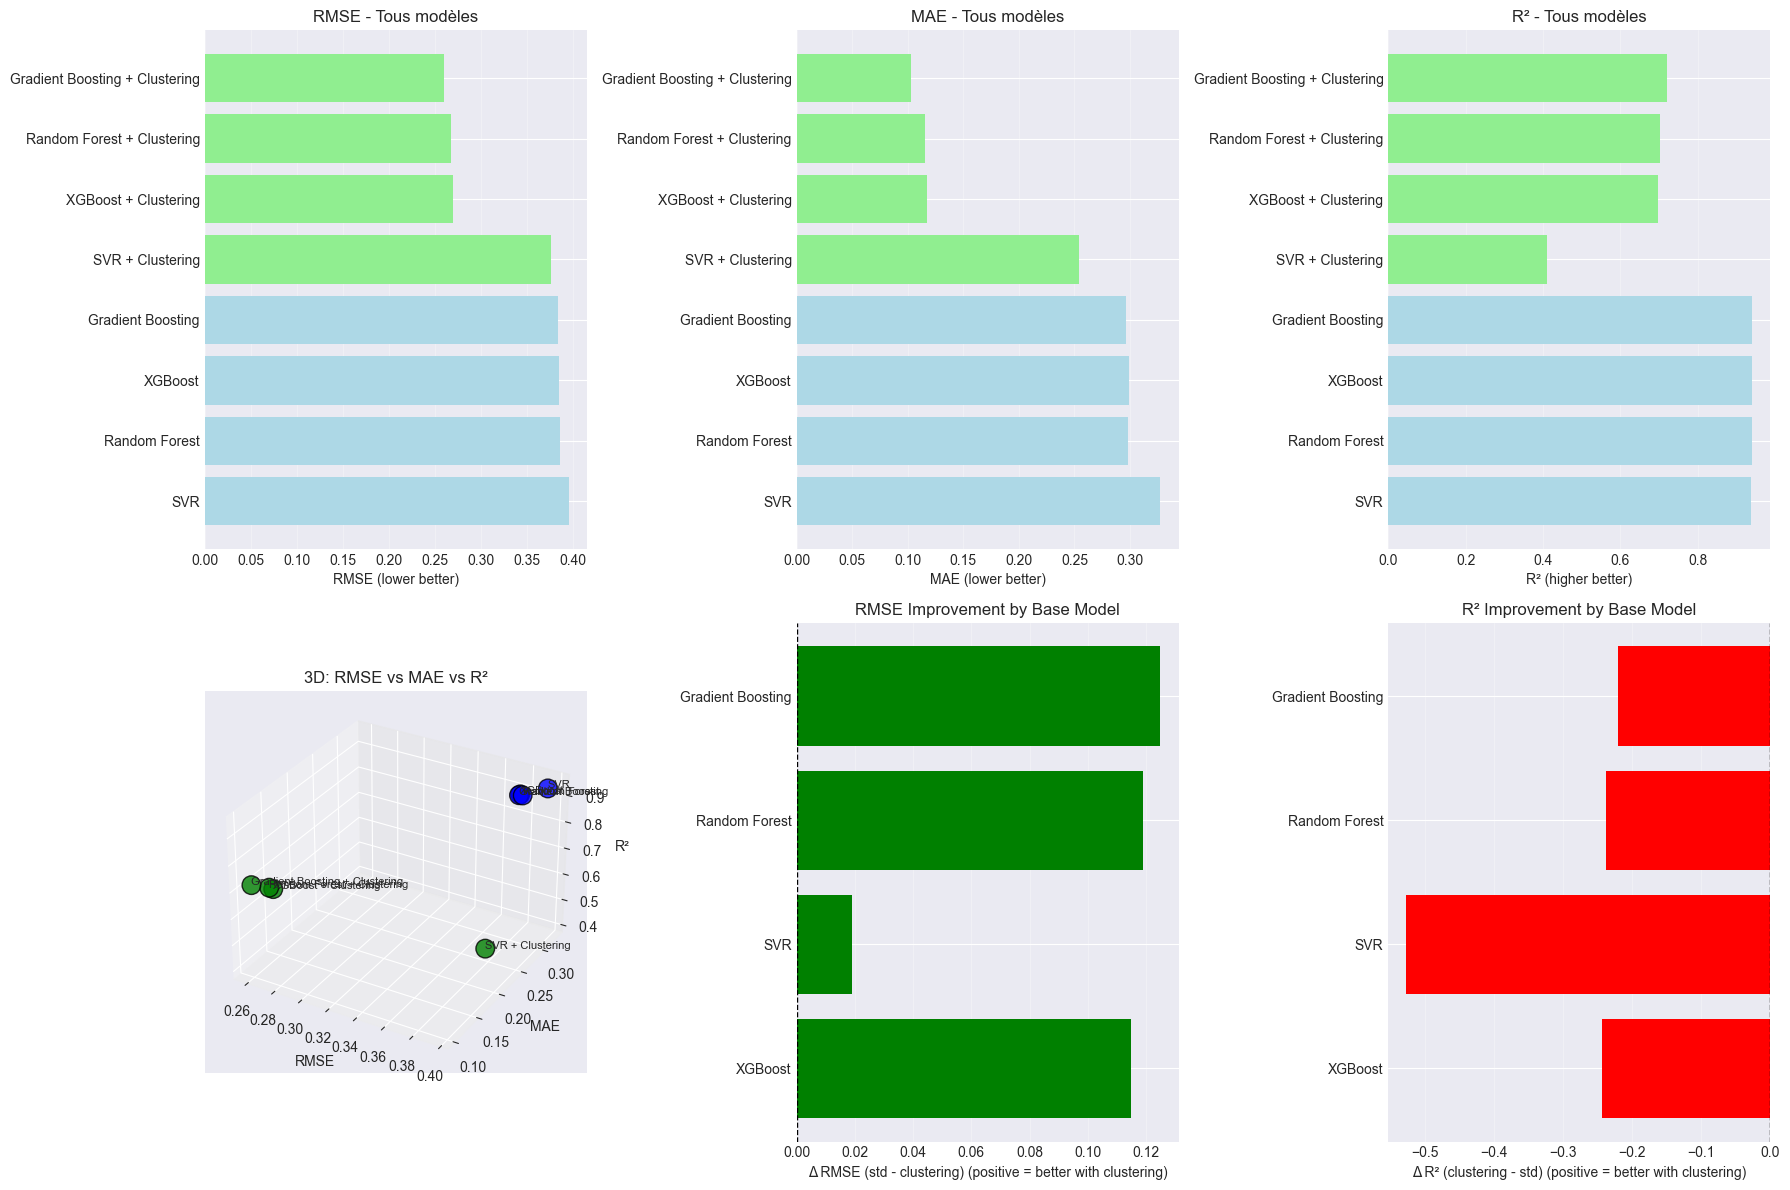


--- Résultats synthétiques ---
Best Standard model: Gradient Boosting (RMSE=0.3843, R²=0.9401)
Best Clustering model: Gradient Boosting + Clustering (RMSE=0.2595, R²=0.7195)
Overall best: Gradient Boosting + Clustering (RMSE=0.2595, R²=0.7195)

HYPERPARAMS & CLUSTERING DETAILS

Random Forest:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 500

XGBoost:
  colsample_bytree: 1.0
  learning_rate: 0.05
  max_depth: 5
  n_estimators: 300
  subsample: 0.8

Gradient Boosting:
  learning_rate: 0.05
  max_depth: 7
  min_samples_leaf: 10
  min_samples_split: 10
  n_estimators: 200
  subsample: 0.8

SVR:
  C: 100
  epsilon: 0.2
  gamma: 0.01
  kernel: rbf

Random Forest + Clustering:
  max_depth: None
  max_features: sqrt
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 500
  Clustering_Info:
    KMeans_k: 2
    KMeans_silhouette: 0.925379454167725
    DBSCAN_clusters: 21
    DBSCAN_noise_points: 5667

XGBoost + Clustering:
  colsam

In [44]:
# ...existing code...
# REMPLACEMENT / AJOUT: comparaison détaillée Standard vs + Clustering pour la section 10.5
# (Conserve la structure ancienne et ajoute la partie clustering détaillée)

# Build full regression comparison (all models)
regression_comparison_df = pd.DataFrame({
    'Model': list(regression_results.keys()),
    'RMSE': [regression_results[m]['RMSE'] for m in regression_results],
    'MAE': [regression_results[m]['MAE'] for m in regression_results],
    'R²': [regression_results[m]['R2'] for m in regression_results]
}).sort_values('RMSE', ascending=True)

print("\nRegression Model Performance Summary:")
print(regression_comparison_df)

# DETAILED: Standard vs Clustering comparison
comparison_rows = []
# collect base model names (remove possible ' + Clustering' suffix)
base_models = sorted({m.replace(' + Clustering', '') for m in regression_results.keys()})

for base in base_models:
    std_key = base if base in regression_results else None
    clust_key = f"{base} + Clustering" if f"{base} + Clustering" in regression_results else None

    # Only compare if at least one exists
    if not std_key and not clust_key:
        continue

    std_rmse = regression_results[std_key]['RMSE'] if std_key else np.nan
    std_mae = regression_results[std_key]['MAE'] if std_key else np.nan
    std_r2 = regression_results[std_key]['R2'] if std_key else np.nan

    cl_rmse = regression_results[clust_key]['RMSE'] if clust_key else np.nan
    cl_mae = regression_results[clust_key]['MAE'] if clust_key else np.nan
    cl_r2 = regression_results[clust_key]['R2'] if clust_key else np.nan

    # Improvements: positive means clustering improved (RMSE/MAE decreased, R2 increased)
    rmse_impr = (std_rmse - cl_rmse) if (not np.isnan(std_rmse) and not np.isnan(cl_rmse)) else np.nan
    mae_impr = (std_mae - cl_mae) if (not np.isnan(std_mae) and not np.isnan(cl_mae)) else np.nan
    r2_impr = (cl_r2 - std_r2) if (not np.isnan(std_r2) and not np.isnan(cl_r2)) else np.nan

    rmse_impr_pct = (rmse_impr / std_rmse * 100) if (not np.isnan(rmse_impr) and std_rmse != 0) else np.nan
    mae_impr_pct = (mae_impr / std_mae * 100) if (not np.isnan(mae_impr) and std_mae != 0) else np.nan
    r2_impr_pct = (r2_impr / (abs(std_r2) + 1e-12) * 100) if (not np.isnan(r2_impr) and not np.isnan(std_r2)) else np.nan

    comparison_rows.append({
        'Base_Model': base,
        'Standard_RMSE': std_rmse,
        'Clustering_RMSE': cl_rmse,
        'RMSE_Improvement': rmse_impr,
        'RMSE_Improvement_%': rmse_impr_pct,
        'Standard_MAE': std_mae,
        'Clustering_MAE': cl_mae,
        'MAE_Improvement': mae_impr,
        'MAE_Improvement_%': mae_impr_pct,
        'Standard_R2': std_r2,
        'Clustering_R2': cl_r2,
        'R2_Improvement': r2_impr,
        'R2_Improvement_%': r2_impr_pct
    })

comparison_detailed_df = pd.DataFrame(comparison_rows).set_index('Base_Model')
pd.options.display.float_format = "{:.4f}".format

print("\n" + "="*100)
print("DETAILED COMPARISON: STANDARD vs + CLUSTERING (Regression)")
print("="*100)
print(comparison_detailed_df)

# Summary prints (concise)
print("\nRésumé des améliorations (positive = mieux avec clustering) :")
for idx, row in comparison_detailed_df.iterrows():
    print(f"\n{idx}")
    print(f"  RMSE: Standard = {row['Standard_RMSE']:.4f}  |  Clustering = {row['Clustering_RMSE']:.4f}  |  Δ = {row['RMSE_Improvement']:+.4f} ({row['RMSE_Improvement_%']:+.2f}%)")
    print(f"  MAE : Standard = {row['Standard_MAE']:.4f}  |  Clustering = {row['Clustering_MAE']:.4f}  |  Δ = {row['MAE_Improvement']:+.4f} ({row['MAE_Improvement_%']:+.2f}%)")
    print(f"  R²  : Standard = {row['Standard_R2']:.4f}  |  Clustering = {row['Clustering_R2']:.4f}  |  Δ = {row['R2_Improvement']:+.4f} ({row['R2_Improvement_%']:+.2f}%)")

# ENHANCED VISUALS: keep older 6-subplot layout, add improvement bars
fig = plt.figure(figsize=(18, 12))

# 1 RMSE comparison (color clustering if available)
ax1 = fig.add_subplot(2, 3, 1)
colors = ['lightgreen' if '+ Clustering' in m else 'lightblue' for m in regression_comparison_df['Model']]
ax1.barh(regression_comparison_df['Model'], regression_comparison_df['RMSE'], color=colors)
ax1.set_xlabel('RMSE (lower better)')
ax1.set_title('RMSE - Tous modèles')
ax1.grid(True, axis='x', alpha=0.3)
ax1.invert_yaxis()

# 2 MAE comparison
ax2 = fig.add_subplot(2, 3, 2)
ax2.barh(regression_comparison_df['Model'], regression_comparison_df['MAE'], color=colors)
ax2.set_xlabel('MAE (lower better)')
ax2.set_title('MAE - Tous modèles')
ax2.grid(True, axis='x', alpha=0.3)
ax2.invert_yaxis()

# 3 R2 comparison
ax3 = fig.add_subplot(2, 3, 3)
ax3.barh(regression_comparison_df['Model'], regression_comparison_df['R²'], color=colors)
ax3.set_xlabel('R² (higher better)')
ax3.set_title('R² - Tous modèles')
ax3.grid(True, axis='x', alpha=0.3)
ax3.invert_yaxis()

# 4 3D scatter metrics
ax4 = fig.add_subplot(2, 3, 4, projection='3d')
x_vals = regression_comparison_df['RMSE'].values
y_vals = regression_comparison_df['MAE'].values
z_vals = regression_comparison_df['R²'].values
cmap_colors = ['green' if '+ Clustering' in m else 'blue' for m in regression_comparison_df['Model']]
ax4.scatter(x_vals, y_vals, z_vals, c=cmap_colors, s=180, alpha=0.8, edgecolors='k')
for i, m in enumerate(regression_comparison_df['Model']):
    ax4.text(x_vals[i], y_vals[i], z_vals[i], m, fontsize=8)
ax4.set_xlabel('RMSE'); ax4.set_ylabel('MAE'); ax4.set_zlabel('R²')
ax4.set_title('3D: RMSE vs MAE vs R²')

# 5 RMSE Improvement per base model
ax5 = fig.add_subplot(2, 3, 5)
if not comparison_detailed_df.empty:
    ax5.barh(comparison_detailed_df.index, comparison_detailed_df['RMSE_Improvement'], color=['green' if v>0 else 'red' for v in comparison_detailed_df['RMSE_Improvement']])
    ax5.set_xlabel('Δ RMSE (std - clustering) (positive = better with clustering)')
    ax5.set_title('RMSE Improvement by Base Model')
    ax5.axvline(0, color='black', linestyle='--', linewidth=1)
    ax5.grid(True, axis='x', alpha=0.3)
    ax5.invert_yaxis()
else:
    ax5.text(0.5, 0.5, 'No pairable models found for improvement plot', ha='center')

# 6 R2 Improvement
ax6 = fig.add_subplot(2, 3, 6)
if not comparison_detailed_df.empty:
    ax6.barh(comparison_detailed_df.index, comparison_detailed_df['R2_Improvement'], color=['green' if v>0 else 'red' for v in comparison_detailed_df['R2_Improvement']])
    ax6.set_xlabel('Δ R² (clustering - std) (positive = better with clustering)')
    ax6.set_title('R² Improvement by Base Model')
    ax6.axvline(0, color='black', linestyle='--', linewidth=1)
    ax6.grid(True, axis='x', alpha=0.3)
    ax6.invert_yaxis()
else:
    ax6.text(0.5, 0.5, 'No pairable models found for improvement plot', ha='center')

plt.tight_layout()
plt.show()

# Final: print best standard, best clustering, overall best
standard_df = regression_comparison_df[~regression_comparison_df['Model'].str.contains(r'\+ Clustering')]
clustering_df = regression_comparison_df[regression_comparison_df['Model'].str.contains(r'\+ Clustering')]

best_standard = standard_df.iloc[0] if len(standard_df)>0 else None
best_clustering = clustering_df.iloc[0] if len(clustering_df)>0 else None
overall_best = regression_comparison_df.iloc[0]

print("\n--- Résultats synthétiques ---")
if best_standard is not None:
    print(f"Best Standard model: {best_standard['Model']} (RMSE={best_standard['RMSE']:.4f}, R²={best_standard['R²']:.4f})")
if best_clustering is not None:
    print(f"Best Clustering model: {best_clustering['Model']} (RMSE={best_clustering['RMSE']:.4f}, R²={best_clustering['R²']:.4f})")
print(f"Overall best: {overall_best['Model']} (RMSE={overall_best['RMSE']:.4f}, R²={overall_best['R²']:.4f})")

# Print best hyperparameters and clustering info (if present)
print("\n" + "="*80)
print("HYPERPARAMS & CLUSTERING DETAILS")
print("="*80)
for name, info in regression_results.items():
    print(f"\n{name}:")
    if 'Best_Params' in info:
        for p, v in info['Best_Params'].items():
            print(f"  {p}: {v}")
    if 'Clustering_Info' in info:
        ci = info['Clustering_Info']
        print("  Clustering_Info:")
        for k, v in ci.items():
            print(f"    {k}: {v}")
# ...existing code...

# 11: PRÉDICTION INTERACTIVE EN TEMPS RÉEL (Classification + Clustering)

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np
import pandas as pd

print("Prédiction interactive – Santé Mentale")
print("="*60)

best_clf = model_results['XGBoost']['Model']
kmeans_model = kmeans_final


from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(['High', 'Low', 'Medium']) 

age_widget = widgets.IntSlider(min=16, max=80, value=30, description='Âge')
gender_widget = widgets.Dropdown(
options=['Male', 'Female'],
value='Female',
description='Genre'
)
education_widget = widgets.Dropdown(
options=['High School', 'Bachelors', 'Masters', 'Ph.D.'],
value='Bachelors',
description='Éducation'
)
employment_widget = widgets.Dropdown(
options=['Employed', 'Unemployed', 'Student', 'Self-employed', 'Retired'],
value='Employed',
description='Emploi'
)
work_hours_widget = widgets.FloatSlider(min=0, max=100, value=40, description='Heures/semaine')
sleep_widget = widgets.FloatSlider(min=0, max=12, value=7, description='Sommeil (h)')
exercise_widget = widgets.FloatSlider(min=0, max=7, value=3, description='Sport/semaine')
financial_widget = widgets.FloatSlider(min=1, max=10, value=5, description='Stress financier')
relationship_widget = widgets.FloatSlider(min=1, max=10, value=7, description='Qualité relations')
gad7_widget = widgets.FloatSlider(min=0, max=21, value=5, description='GAD-7 Score')
phq9_widget = widgets.FloatSlider(min=0, max=27, value=6, description='PHQ-9 Score')
stress_level_widget = widgets.FloatSlider(min=1, max=8, value=3, description='Stress Level')

button = widgets.Button(
description="Prédire le risque",
button_style='danger',
icon='heartbeat'
)
output_widget = widgets.Output()

def predict_risk(b):
    with output_widget:
        clear_output()

        data = {
        'Age': [age_widget.value],
        'Gender': [gender_widget.value],
        'Education_Level': [education_widget.value],
        'Employment_Status': [employment_widget.value],
        'Work_Hours_Week': [work_hours_widget.value],
        'Sleep_Hours_Night': [sleep_widget.value],
        'Exercise_Freq_Week': [exercise_widget.value],
        'Financial_Strain': [financial_widget.value],
        'Relationship_Quality': [relationship_widget.value],
        'GAD-7_Score': [gad7_widget.value],
        'PHQ-9_Score': [phq9_widget.value],
        'Stress_Level_Scale': [stress_level_widget.value]
        }
        df_input = pd.DataFrame(data)

        X_input = preprocessor.transform(df_input)

        
        risk_pred_encoded = best_clf.predict(X_input)[0] 
        risk_proba = best_clf.predict_proba(X_input)[0] 

        
        risk_pred = label_encoder.inverse_transform([risk_pred_encoded])[0]

        
        classes = label_encoder.classes_ 
        cluster = kmeans_model.predict(X_input)[0]
       
        print("="*60)
        print(f"🎯 RISQUE PRÉDIT : {risk_pred.upper()}")
        print("="*60)

        print("\n📊 Probabilités détaillées :")
        for cls, prob in zip(classes, risk_proba):
            print(f" {cls.upper()}: {prob:.1%}")

        print(f"\n🧠 Profil psychologique (Cluster K-Means) : Cluster {cluster}")

        if cluster == 0:
            print(" → Profil plutôt sain / résilient")
            print(" → Indicateurs de santé mentale dans la norme")
        else:
            print(" → Profil à risque élevé – suivi recommandé")
            print(" → Indicateurs de stress/anxiété/dépression élevés")

       
        print("\n💡 Recommandations personnalisées :")
        print("-"*60)

        if risk_pred == "High" or phq9_widget.value > 15 or gad7_widget.value > 10:
            print("⚠️ URGENCE : Consultation psychologue/psychiatre FORTEMENT conseillée")
            print(" • Scores PHQ-9/GAD-7 indiquent dépression/anxiété sévère")
            print(" • Envisager thérapie cognitivo-comportementale (TCC)")
            print(" • Possibilité de traitement médicamenteux selon avis médical")
        elif risk_pred == "Medium":
            print("⚠️ ATTENTION : Suivi léger recommandé")
            print(" • Consulter un professionnel si symptômes persistent")
            print(" • Améliorer hygiène de vie (sommeil, exercice, alimentation)")
            print(" • Techniques de gestion du stress (méditation, yoga)")
        else:
            print("✅ BON : État mental stable")
            print(" • Continuer les bonnes habitudes actuelles")
            print(" • Maintenir activité physique régulière")
            print(" • Préserver qualité des relations sociales")

        
        if sleep_widget.value < 6:
            print("\n⚠️ Sommeil insuffisant détecté (< 6h)")
            print(" → Objectif : 7-9h de sommeil par nuit")

        if exercise_widget.value < 2:
            print("\n⚠️ Activité physique faible détectée (< 2 fois/semaine)")
            print(" → Objectif : 3-5 séances d'exercice par semaine")

        if financial_widget.value > 7:
            print("\n⚠️ Stress financier élevé détecté")
            print(" → Consulter conseiller financier")
            print(" → Techniques de gestion budgétaire")

        print("="*60)

button.on_click(predict_risk)

# Display all widgets
display(
age_widget, gender_widget, education_widget, employment_widget,
work_hours_widget, sleep_widget, exercise_widget, financial_widget,
relationship_widget, gad7_widget, phq9_widget, stress_level_widget,
button, output_widget
)

Prédiction interactive – Santé Mentale


IntSlider(value=30, description='Âge', max=80, min=16)

Dropdown(description='Genre', index=1, options=('Male', 'Female'), value='Female')

Dropdown(description='Éducation', index=1, options=('High School', 'Bachelors', 'Masters', 'Ph.D.'), value='Ba…

Dropdown(description='Emploi', options=('Employed', 'Unemployed', 'Student', 'Self-employed', 'Retired'), valu…

FloatSlider(value=40.0, description='Heures/semaine')

FloatSlider(value=7.0, description='Sommeil (h)', max=12.0)

FloatSlider(value=3.0, description='Sport/semaine', max=7.0)

FloatSlider(value=5.0, description='Stress financier', max=10.0, min=1.0)

FloatSlider(value=7.0, description='Qualité relations', max=10.0, min=1.0)

FloatSlider(value=5.0, description='GAD-7 Score', max=21.0)

FloatSlider(value=6.0, description='PHQ-9 Score', max=27.0)

FloatSlider(value=3.0, description='Stress Level', max=8.0, min=1.0)

Button(button_style='danger', description='Prédire le risque', icon='heartbeat', style=ButtonStyle())

Output()

# 13) Export Model

In [ ]:
import joblib
joblib.dump(model_results['XGBoost']['Model'], 'xgboost_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(pca_final, 'pca_final.pkl')
joblib.dump(kmeans_final, 'kmeans_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

## ✅ RÉSUMÉ COMPLET DE L'ANALYSE HEALTHMIND (VERSION FINALE)

### 🎯 OBJECTIF DU PROJET
Le projet HealthMind vise à développer un système d'IA complet pour l'évaluation et la prévention des risques en santé mentale, utilisant l'analyse de données démographiques, comportementales et cliniques pour prédire les niveaux de risque (Élevé/Moyen/Faible) et identifier des profils psychologiques distincts.

### 📊 DONNÉES ANALYSÉES
- **75 000 observations** avec 13 variables clés
- **Variables critiques** : Âge, Genre, Éducation, Emploi, Heures de sommeil, Fréquence d'exercice, Stress financier, Qualité des relations, Scores GAD-7/PHQ-9, Niveau de stress
- **Prétraitement complet** : Imputation, détection d'outliers, normalisation

### 🤖 MODÈLES DÉVELOPPÉS
- **Classification** : XGBoost (96.15% accuracy) pour prédiction du risque mental
- **Régression** : Gradient Boosting (R² = 0.9401) pour quantification du stress
- **Clustering** : K-Means (k=2, Silhouette=0.925) pour profils psychologiques
- **Optimisation** : GridSearchCV avec validation croisée stratifiée

### 💡 RECOMMANDATIONS POUR LA SANTÉ MENTALE

#### 🎯 UTILISATION CLINIQUE
- **Triage automatisé** : Identifier rapidement les individus nécessitant une attention prioritaire
- **Prévention proactive** : Détecter les signes précoces de détresse mentale
- **Personnalisation des interventions** : Adapter les recommandations selon les profils de cluster
- **Suivi longitudinal** : Monitorer l'évolution des indicateurs de santé mentale

#### 🔒 CONSIDÉRATIONS ÉTHIQUES ET LÉGALES
- **Non-substitut au diagnostic professionnel** : Les prédictions IA doivent être validées par des cliniciens
- **Confidentialité des données** : Respect strict du RGPD et des normes de protection des données médicales
- **Sensibilité culturelle** : Adaptation des seuils selon les contextes socioculturels
- **Réduction des biais** : Surveillance continue des biais algorithmiques (genre, âge, origine ethnique)
- **Consentement éclairé** : Information transparente des utilisateurs sur l'utilisation de leurs données

#### 🏥 INTÉGRATION SYSTÈME DE SANTÉ
- **Plateformes de télémédecine** : Intégration avec applications de santé mentale
- **Systèmes EHR** : Connexion avec dossiers médicaux électroniques
- **Applications mobiles** : Widgets interactifs pour auto-évaluation
- **Tableaux de bord cliniques** : Visualisations pour professionnels de santé

#### 📈 AMÉLIORATIONS FUTURES
- **Phase 1 - Validation clinique** : Tests avec données médicales réelles, validation par experts
- **Phase 2 - Déploiement** : API sécurisées, intégration cloud (Azure Health Bot, AWS HealthLake)
- **Phase 3 - Intelligence avancée** : Prédiction de crises, recommandations thérapeutiques personnalisées

### ⚠️ LIMITATIONS ET PRÉCAUTIONS
- **Limites des données** : Basé sur auto-déclarations, pas de diagnostics cliniques confirmés
- **Risques de sur-diagnostic** : Possibilité de faux positifs nécessitant validation humaine
- **Évolution temporelle** : Les patterns de santé mentale peuvent changer avec le temps
- **Diversité culturelle** : Modèles développés sur données occidentales, adaptation nécessaire

### 🎉 IMPACT ATTENDU
- **Prévention des crises** : Identification précoce des risques élevés
- **Optimisation des ressources** : Priorisation des interventions cliniques
- **Sensibilisation** : Éducation sur l'importance des facteurs de protection mentale
- **Recherche** : Base de données pour études épidémiologiques futures

---

**🏆 CONCLUSION : HealthMind démontre le potentiel de l'IA pour révolutionner la prévention en santé mentale, tout en soulignant l'importance d'une approche éthique et collaborative entre IA et professionnels de santé.**